<font size="6">Рекуррентные нейронные сети (RNN)</font>

#  Особенности данных

В предыдущих лекциях мы работали с данными **фиксированной длины**, у которых не было **временной связности**.

Если это **табличные данные**, то мы заранее знаем длину вектор-описания объекта, а также размер выхода модели: одно это число или вектор.

Верно это и про **изображения** — обычно нейронная сеть учится на изображениях определенного разрешения. Да, мы можем сделать нейросеть, которая способна работать с изображением почти любого разрешения, но добиваемся мы этого за счет вставки слоев **global pooling**, которые  приводят признаковое описание, полученное сверточной частью нейросети, к фиксированному размеру.

Однако далеко **не все данные фиксированного размера**. К примеру, **тексты**. Возьмем все абзацы из "Войны и Мира". Какие-то будут больше, какие-то меньше. А ещё нам важна последовательность слов и предложений.

Или если на основе абзаца текста нам необходимо сгенерировать его **краткое содержание**? То, что нужно предсказать, может быть разной длины. Аналогичный вопрос возникает также в случае, если мы хотим по данным о курсе валюты за прошлый год спрогнозировать **курс валюты на следующий месяц** по дням.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L09/out/time_series_data.png" width="700"></center>

Но, может, справимся уже имеющимися инструментами?



## Теория и классические подходы

##Разделение данных



Обратите внимание на разбиение временного ряда на **train-val-test**.

Если мы поделим ряд на отрезки, точки склейки будут легко предсказываться либо предыдущим, либо средним значением по отрезку. Нужно предсказывать крупные отрезки ряда. И помнить о том, что перемешивать данные нельзя — есть "прошлое" и "будущее".


<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L09/fixed_partitioning.jpg" width="700"></center>

<center><em>Source: <a href="https://yuting3656.github.io/yutingblog/coursera-tensorflow-developer-professional-certificate/sequences-time-series-and-prediction/week01-03">Coursera: Sequences, Time Series and Prediction with TensorFlow</a></em></center>

### Компоненты

Основные понятия в статистическом анализе временных рядов:

**Тренд** — компонента, описывающая долгосрочное изменение уровня ряда.

**Сезонность** — компонента, обозначаемая как $Q$, описывает циклические изменения уровня ряда.

**Ошибка (random noise)** — непрогнозируемая случайная компонента, описывает нерегулярные изменения в данных, необъяснимые другими компонентами.

$$\large y_i = T + S + ϵ_i$$

**Автокорреляция** — статистическая взаимосвязь между последовательностями величин одного ряда. Это один из самых важных коэффициентов в анализе временного ряда. Чтобы посчитать автокорреляцию, используется корреляция между временным рядом и её сдвинутой копией от величины временного сдвига. Сдвиг ряда называется лагом.

**Автокорреляционная функция** — автокорреляция при разных лагах, помогает находить повторяющиеся участки сигнала. График называется **коррелограммой**.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L09/autocorrelation_graph.png" width="700"></center>

<center><em>Source: <a href="https://habr.com/ru/articles/693562/">Анализ временных рядов, применение нейросетей (1 часть)</a></em></center>

### Пример

Возьмем датасет [Air Passengers 🛠️[doc]](https://www.kaggle.com/rakannimer/air-passengers), который содержит данные о количестве пассажиров за каждый месяц.


In [ ]:
import pandas as pd

dataset = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/airline-passengers.csv"
)
dataset.head()

Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121

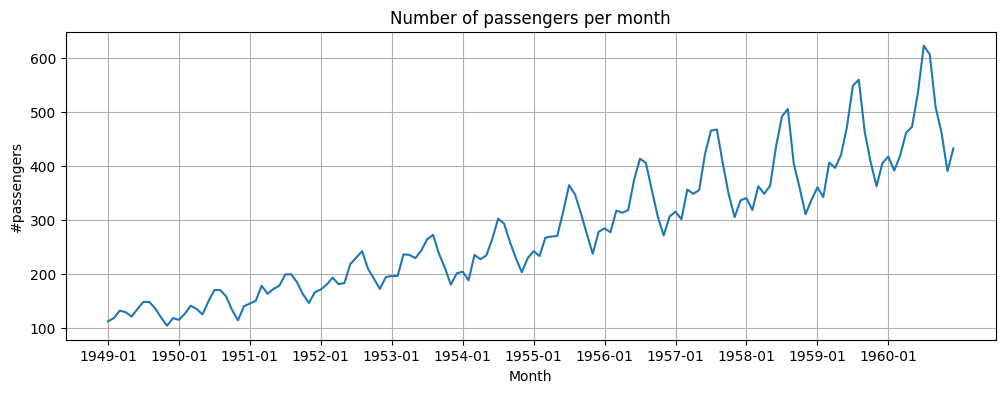

In [ ]:
import matplotlib.pyplot as plt

training_data = dataset.iloc[:, 1:2].values  # transform dataframe to numpy.array
# plotting
plt.figure(figsize=(12, 4))
plt.plot(training_data, label="Airline Passangers Data")
plt.title("Number of passengers per month")
plt.ylabel("#passengers")
plt.xlabel("Month")
labels_to_display = [i for i in range(training_data.shape[0]) if i % 12 == 0]
plt.xticks(labels_to_display, dataset["Month"][labels_to_display])
plt.grid()
plt.show()

**Сделаем стационарнее**

Мы можем видеть четкую сезонность и тенденцию к увеличению в данных.

Тенденция и сезонность являются фиксированными компонентами, которые могут быть добавлены к любому нашему прогнозу. Они полезны, но должны быть удалены, чтобы изучить любые другие систематические сигналы, которые могут помочь сделать прогнозы.

Временной ряд с сезонностью и удаленными трендами называется стационарным.

Чтобы убрать сезонность, мы можем взять сезонную разницу, которая приведет к так называемым сезонно скорректированным временным рядам.

Период сезонности составляет один год (12 месяцев). Приведенный ниже код рассчитывает сезонно скорректированный временной ряд и сохраняет его в файл «seasonally_adjusted.csv».

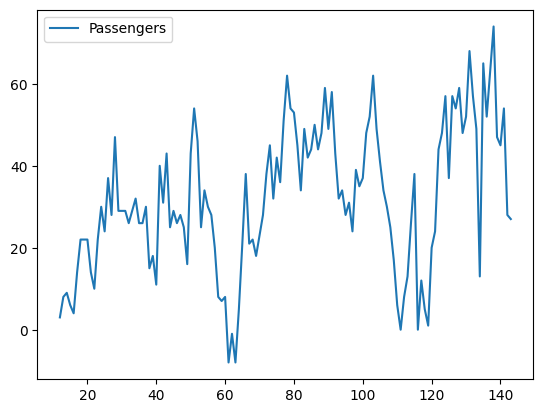

In [ ]:
# seasonal difference
differenced = dataset.iloc[:, 1:2].diff(12)
# trim off the first year of empty data
differenced = differenced[12:]
# save differenced dataset to file
differenced.to_csv("seasonally_adjusted.csv", header=None, index=False)
# plot differenced dataset
differenced.plot()
plt.show()

Поскольку данные за первые 12 месяцев не имеют предварительных данных, с которыми можно было бы провести сравнение, они должны быть отброшены.

**Коррелограмма**

Показывает корреляцию каждого отсроченного наблюдения и позволяет оценить ее статистическую значимость.

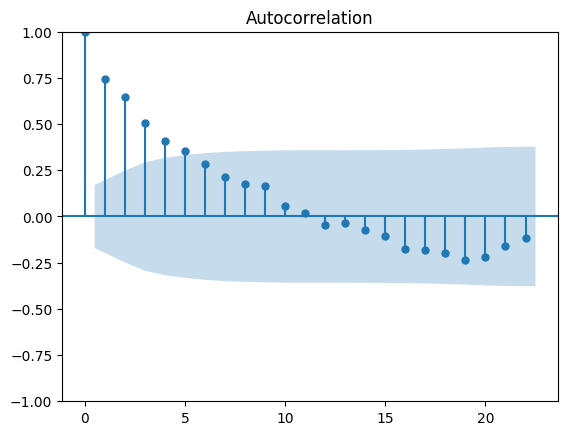

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

sa = pd.read_csv("seasonally_adjusted.csv", header=None)
plot_acf(sa)
plt.show()

На графике показаны значения запаздывания по оси $X$ и корреляции по оси $Y$ между $-1$ и $1$ для отрицательно и положительно коррелированных лагов соответственно. Точки над синей областью указывают на статистическую значимость. Это зона достоверности, по умолчанию на $0.05$.

* Корреляция $1$ для значения отставания $0$ указывает на $100\%$ положительную корреляцию наблюдения с самим собой.
* Вторая точка находится в районе $0.75$, что означает, что следующая точка на $75\%$ описывается предыдущим значением.

## Статистические модели предсказания

**Авторегрессионная модель** (Autoregression method (AR))

Линейная модель, в которой прогнозированная величина является суммой прошлых значений, умноженных на числовой множитель.

$$\large X_t = C + ϕ_1X_{t-1}+ϕ_2X_{t-2}...+ ϵ_t$$

**Скользящее среднее** (Moving average method (MA))

Расчет точек путем создания ряда средних значений различных подмножеств полного набора данных.

$$\large \text{MA}_k=  \frac {p_{n-k+1} + p_{n-k+2} ... p_{n}} {k} = \frac {1}{k} \sum ^ {n} _{i= n-k+1} p_i $$

Скользящее среднее часто применяется для анализа временных рядов акций.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L09/moving_average_method.png" width="700"></center>

<center><em>Source: <a href="https://habr.com/ru/articles/693562/">Анализ временных рядов, применение нейросетей (1 часть)</a></em></center>

**ARIMA**

Метод скользящего среднего с авторегрессией и интегрированием (Autoregressive integrated moving average (ARIMA) и разновидности: Seasonable ARIMA, ARIMAX и пр.).

Для использования модели временной ряд должен быть **стационарным**, т.е. его **среднее и дисперсия должны быть постоянны**.



Для стационарных процессов используется модель **ARMA(p,q)**, которая в общем виде выглядит следующим образом:

$$\large y_t = α_1y_{t-1} + ⋯ + α_py_{t-p}	 + ε_t + θ_1y_{t-1} + ⋯ + θ_qy_{t-q},$$

где $a_t$ — коэффициенты авторегрессионной части модели, $ε_t$ — значения ошибки (полагаются независимыми одинаково распределёнными случайными величинами из нормального распределения с нулевым средним), $θ_j$ — коэффициенты скользящего среднего.

Если процесс оказывается нестационарным и для приведения его к
стационарному виду требуется взять несколько разностей, то модель
становится **ARIMA(p,d,q)**.

Модель предполагает, что временной ряд содержит три составляющие: авторегресионную, интегрированную и скользящее среднее, которые в модели обозначены $p, d$ и $q$  соответственно:

* $p$ — порядок авторегрессии. Позволяет ответить на вопрос, будет ли очередной элемент ряда близок к значению $X$, если к нему были близки $p$ предыдущих значений.
* $d$ — порядок интегрирования. Показывает, насколько элемент ряда близок по значению к $d$  предыдущим значениям, если разность между ними минимальна.
* $q$ — порядок скользящего среднего. Позволяет установить погрешность модели как линейную комбинацию наблюдавшихся ранее значений ошибок.

**ARIMA(p,d,q)**:

$$ \large (Δ^dy_t) = \sum ^p _{t=1} α_t(Δ^dy_{t-1}) + ε_t + \sum ^q _{j=1} θ_j(Δ^d ε_{t-j}) $$

[[blog] ✏️ Обсуждение на Machinelearning Mastery](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)

Воспользуемся библиотечной реализацией. Тем более, что период мы уже вычислили.

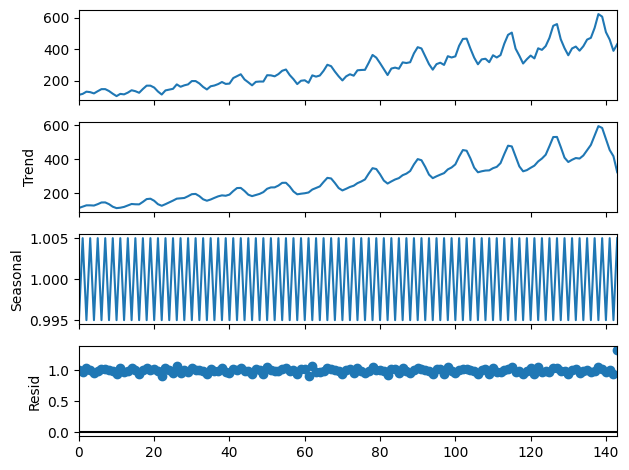

In [ ]:
# from plotly.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose

data = dataset.iloc[:, 1:2]
result = seasonal_decompose(
    x=data, model="multiplicative", extrapolate_trend="freq", period=2
)
# result_add = seasonal_decompose(x=df_test['listData'], model='additive', extrapolate_trend='freq', period=1)
fig = result.plot()
# plot_mpl(fig)
plt.show()

Воспользуемся библиотечной версией ARIMA. Разобьём данные и поставим параметры произвольно. Обучим модель.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

train_data, test_data = data[0 : int(len(data) * 0.9)], data[int(len(data) * 0.9) :]

train_arima, test_arima = train_data.values, test_data.values

history = [x for x in train_arima]

y = test_arima
# make first prediction
predictions = list()
model = ARIMA(history, order=(1, 1, 0))
model_fit = model.fit()
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])

Сделаем предсказания.

In [ ]:
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(1, 1, 0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)

Оценим метрики. Здесь они нужны лишь для того, чтобы оценивать измнения между моделями с различными параметрами.

In [ ]:
# report performance
mse = mean_squared_error(y, predictions)
print("MSE: " + str(mse))
mae = mean_absolute_error(y, predictions)
print("MAE: " + str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print("RMSE: " + str(rmse))

MSE: 2326.407437847587
MAE: 41.3368890696388
RMSE: 48.23284604755961


Визуализируем.

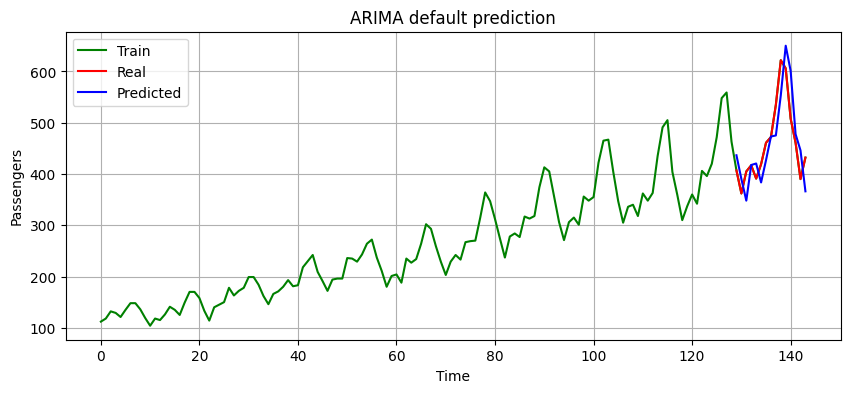

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(data.index, data, color="green", label="Train")
plt.plot(test_data.index, y, color="red", label="Real")
plt.plot(test_data.index, predictions, color="blue", label="Predicted")
plt.title("ARIMA default prediction")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.show()

[[blog] ✏️ Forecasting Time Series with Auto-Arima](https://www.alldatascience.com/time-series/forecasting-time-series-with-auto-arima/)

Предсказание есть, однако можно ли его как-то улучшить? Да так, чтобы без ручного анализа и подбора параметров?

In [ ]:
!pip install -q pmdarima

In [ ]:
from pmdarima.arima import auto_arima

stepwise_model = auto_arima(
    data,
    start_p=1,
    start_q=1,
    max_p=3,
    max_q=3,
    m=12,
    start_P=0,
    seasonal=True,
    d=1,
    D=1,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1022.896, Time=0.34 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.23 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.69 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.22 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=1.68 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=1.01 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=1.90 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=1.79 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.90 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.35 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=5.67 sec
 ARIMA(0,1,1)(1,1,1)[12]     

In [ ]:
stepwise_model.fit(train_data)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
future_forecast = stepwise_model.predict(n_periods=len(test_data))
# This returns an array of predictions:
print(future_forecast)

129    414.788841
130    365.328447
131    392.065364
132    412.697013
133    393.151099
134    453.793271
135    442.548857
136    466.990043
137    521.443373
138    597.703538
139    610.767471
140    508.614087
141    462.484806
142    412.008287
143    438.164562
dtype: float64


In [ ]:
future_forecast = pd.DataFrame(
    future_forecast, index=test_data.index, columns=["Prediction"]
)
test_preds = pd.concat([test_data, future_forecast], axis=1)

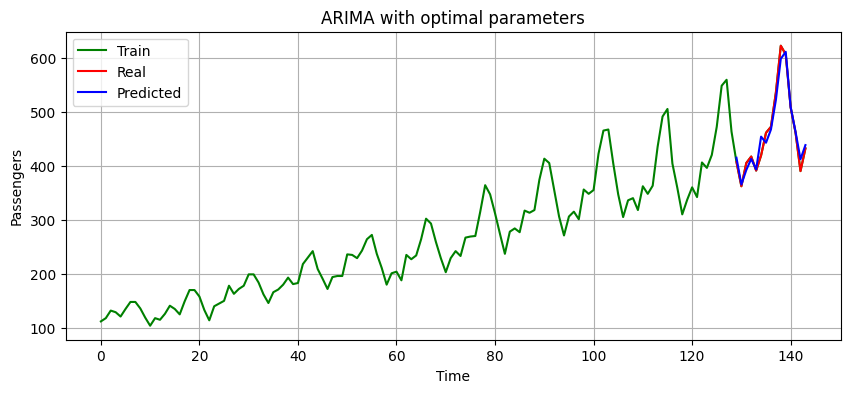

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(data.index, data, color="green", label="Train")
plt.plot(test_preds.index, test_preds["Passengers"], color="red", label="Real")
plt.plot(test_preds.index, test_preds["Prediction"], color="blue", label="Predicted")
plt.title("ARIMA with optimal parameters")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# report performance
mse = mean_squared_error(test_preds["Passengers"], test_preds["Prediction"])
print("MSE: " + str(mse))
mae = mean_absolute_error(test_preds["Passengers"], test_preds["Prediction"])
print("MAE: " + str(mae))
rmse = math.sqrt(mean_squared_error(test_preds["Passengers"], test_preds["Prediction"]))
print("RMSE: " + str(rmse))

MSE: 210.6723813356807
MAE: 10.776845688682746
RMSE: 14.514557565963928


Получилось лучше по метрикам и визуально.

# Области применения рекуррентных сетей

In [ ]:
# отлично работают с небольщим колвом данных, где есть мат ряды, например спектры

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L09/standard_solar_spectrum.png" width="600"></center>

<center><em>Source: <a href="https://www.researchgate.net/publication/280041456_THERMAL_PERFORMANCE_OF_WHITE_SOLAR-REFLECTIVE_PAINTS_FOR_COOL_ROOFS_AND_THE_INFLUENCE_ON_THE_THERMAL_COMFORT_AND_BUILDING_ENERGY_USE_IN_HOT_CLIMATES?_tp=eyJjb250ZXh0Ijp7ImZpcnN0UGFnZSI6Il9kaXJlY3QiLCJwYWdlIjoiX2RpcmVjdCJ9fQ">Research Gate</a></em></center>



До бурного развития архитектуры **Трансформер**, о которой будет рассказано в соответствующей лекции, **рекуррентные сети** применялись в широком перечне задач, от **распознавания речи** до **генерации подписей** к изображениям. Общее для задач — возможность сохранять информацию, сформированную при обработке одной части объекта (**токена**), и использовать ее при анализе других частей.

В настоящий момент рекуррентные сети держат первенство **в обработке временных рядов**, а также являются частью гибридных моделей.

Хотя Трансформеры, как правило, превосходят RNN с точки зрения точности, важно помнить о необходимых вычислительных ресурсах. По своей сути большое количество параметров и слоев в Трансформерах приводит к критическому увеличению объема необходимой памяти и вычислительных требований по сравнению с RNN.



#Основная идея

In [ ]:
# размечать спектры вручную очень долго времени

**Основная идея**, на которой основаны рекуррентные нейронные сети (RNN), состоит в следующем: взять всю последовательность и пропустить через одну и ту же нейросеть.
Но при этом сама нейросеть кроме следующего элемента последовательности (например, слова в тексте) будет принимать еще один параметр — некий $h$, который в начале будет, например, вектором из нулей, а далее — значением, которое выдает сама нейросеть после обработки очередного элемента последовательности (**токена**).

Также далее мы будем использовать понятие **нулевого токена** — токена, который символизирует заплатку и не несёт никакого смысла, но который иногда нужно передать модели, например, как сигнал начала работы.

В сети появляется новая сущность — **hidden state** ($h$) — вектор, хранящий состояние, учитывающее и локальный, и глобальный контекст.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L09/out/rnn_basic_block.png" width="700"></center>


# Базовый RNN блок

Рассмотрим работу рекуррентной нейронной сети:
1. На вход поступает некоторая последовательность $x = \{x_1,...x_t,...,x_n\}$, где $x_i$ — вектор фиксированной размерности. В ряде случаев этот вектор имеет размерность $1$.

2. Для каждого поступившего $x_t$ формируем скрытое состояние $h_t$, которое является функцией от предыдущего состояния $h_{t-1}$ и текущего элемента последовательности $x_t$:
$$\large h_t = f_W(h_{t-1}, x_t),$$
где $W$  — это обучаемые параметры (веса).

3. На основании рассчитанного скрытого состояния, учитывающего предыдущие значения  $x_i$, формируется выходная последовательность $y = \{y_1,...y_t,...,y_k\}$. Для формирования предсказания $y_t$ в текущий момент времени в модель могут быть добавлены полносвязные слои, принимающие на вход текущее скрытое состояние $h_t$.

**Простейшая RNN**. Мы можем обрабатывать последовательность элементов вектора $x$ за счет применения рекуррентной формулы на каждом шаге:

$\large h_t = f_W(h_{t-1}, x_t),$

$\large \quad \quad \quad \color{grey}{\downarrow \text{(также может добавляться bias)}}$

$\large h_t = \tanh(W_{hh}h_{t-1} + W_{xh}x_t).$

$\large y_t = W_{hy}h_t.$

**Отличие** от слоев, с которыми мы уже сталкивались, состоит в том, что **на выходе мы получаем два объекта** — $y_t$ и $h_t$:

$y_t$ — предсказание в текущий момент времени, например, метка класса,

$h_t$ — контекст, в котором предсказание было сделано. Он может использоваться для дальнейших предсказаний.

## RNNCell

В PyTorch для вычисления $h_t$ используется модуль `torch.nn.RNNCell` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html).

$y_t$ в нем не вычисляется: предполагается, что для его получения в модель должен быть добавлен дополнительный линейный слой.

**`input_size`** — размер элемента последовательности.

В отличие от сверточных слоёв, это всегда вектор, а не тензор, поэтому **`input_size`** — скаляр.

**`hidden_size`** — тоже скаляр. Он задает размер скрытого состояния, которое тоже является вектором. Фактически это количество нейронов в слое.


In [ ]:
import torch

rnn_cell = torch.nn.RNNCell(input_size=3, hidden_size=2)
dummy_sequence = torch.randn((1, 3))  # batch, input_size
h = rnn_cell(dummy_sequence)
print("Inital shape:".ljust(17), f"{dummy_sequence.shape}")
print("Resulting shape:".ljust(17), f"{h.shape}")  # hidden state

Inital shape:     torch.Size([1, 3])
Resulting shape:  torch.Size([1, 2])


Внутри происходит примерно то, что описано в коде ниже.
Для понятности в данном примере опущена батчевая обработка. Также для того, чтобы подобный код корректно заработал, [необходимо обернуть веса ✏️[blog]](https://stackoverflow.com/questions/50935345/understanding-torch-nn-parameter) в `torch.nn.Parameter` для регистрации параметров в модели.

Начальное значение может быть инициализировано нулями, но лучше инициализировать случайными значениями.

In [ ]:
from torch import nn


# Simple RNNcell without a bias and batch support
class SimplifiedRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        # Init weight matrix, for simplicity omit bias
        self.W_hx = (
            torch.randn(input_size, hidden_size) * 0.0001
        )  # hidden_size == number of neurons
        self.W_hh = (
            torch.randn(hidden_size, hidden_size) * 0.0001
        )  # naive initialization
        self.h0 = torch.zeros((hidden_size))  # Initial hidden state

    def forward(self, x, h=None):  # Without a batch dimension
        if h is None:
            h = self.h0
        h = torch.tanh(torch.matmul(self.W_hx.T, x) + torch.matmul(self.W_hh.T, h))
        return h


simple_rnn_cell = SimplifiedRNNCell(input_size=3, hidden_size=2)
h = simple_rnn_cell(dummy_sequence[0])  # No batch
print(f"Out = h\n{h.shape} \n{h}")

Out = h
torch.Size([2]) 
tensor([0.0002, 0.0002])


Однако в последовательности всегда **несколько элементов**. И надо применить алгоритм к каждому.


Поэтому `torch.nn.RNNCell` напрямую не используется. Для него есть обертка — `torch.nn.RNN` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html), которая обеспечивает последовательный вызов RNNCell для всех элементов последовательности.

### RNN блок в PyTorch

**Формат данных для RNN: длина последовательности, батч, размер объекта**.



In [ ]:
rnn = torch.nn.RNN(input_size=3, hidden_size=2, batch_first = False)  # batch_first = True
dummy_batched_seq = torch.randn((2, 1, 3))  # seq_len, batch, input_size
out, h = rnn(dummy_batched_seq)

print("Inital shape:".ljust(20), f"{dummy_batched_seq.shape}")
print("Resulting shape:".ljust(20), f"{out.shape}")
print("Hidden state shape:".ljust(20), f"{h.shape}")

Inital shape:        torch.Size([2, 1, 3])
Resulting shape:     torch.Size([2, 1, 2])
Hidden state shape:  torch.Size([1, 1, 2])


Внутри происходит примерно следующее:

In [ ]:
import numpy as np


# Simple RNN without batching
class SimplifiedRNNLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.rnn_cell = SimplifiedRNNCell(input_size, hidden_size)

    # Without a batch dimension x have shape seq_len * input_size
    def forward(self, x, h=None):
        all_h = []
        for i in range(x.shape[0]):  # iterating over timestamps
            h = self.rnn_cell(torch.Tensor(x[i]), h)
            all_h.append(h)
        return np.stack(all_h), h


simple_rnn = SimplifiedRNNLayer(input_size=4, hidden_size=2)

sequence = np.array(
    [[0, 1, 2, 0], [3, 4, 5, 0]]
)  # batch with one sequence of two elements

out, h = simple_rnn(sequence)
print("Inital shape:".ljust(20), f"{sequence.shape}")
print("Resulting shape:".ljust(20), f"{out.shape}")
print("Hidden state shape:".ljust(20), f"{h.shape}")

Inital shape:        (2, 4)
Resulting shape:     (2, 2)
Hidden state shape:  torch.Size([2])


Давайте разберемся.

Если у нас есть две последовательности:

*   [1, 3, 2]
*   [0, 4, 2]

Чтобы обработать элемент "3", нам нужен hidden state, вычисленный по "1".

То же самое для "4" — нужно обработать "0". Таким образом, по горизонтальной оси мы не можем распараллелить вычисления, придётся делать это по вертикальной. Мы можем параллельно обработать первые элементы первой и второй последовательностей.

К данным добавляется еще одно измерение — **размер последовательности**. Batch из 5 последовательностей по 6 объектов (размер объекта 3) в каждой будет выглядеть так (время идёт первой размерностью, поэтому поэлементно идём "сверху вниз"):

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L09/out/rnn_batch.png" width="700">

<em>Source: <a href="https://www.researchgate.net/publication/284579100_Session-based_Recommendations_with_Recurrent_Neural_Networks">Session-based Recommendations with Recurrent Neural Networks</a></em>

Внутри RNN-модуля элементы последовательности обрабатываются последовательно:

<img src = "https://edunet.kea.su/repo/EduNet-content/dev-2.0/L09/out/simple_rnn_h_state.png" width="700">

Веса при этом используются одни и те же.

In [ ]:
dummy_seq = torch.randn((2, 1, 3))  #  seq_len, batch, input_size

print("RNNCell")
rnn_cell = torch.nn.RNNCell(3, 2)
print("Parameter".ljust(10), "Shape")
for t, p in rnn_cell.named_parameters():
    print(t.ljust(10), p.shape)

cell_out = rnn_cell(dummy_seq[0, :, :])  # take first element from sequence
print()
print("Result shape =".ljust(20), cell_out.shape)
print("Hidden state shape =".ljust(20), cell_out.shape)  # one hidden state

print("----------------------------------------")

print("RNN")
rnn = torch.nn.RNN(3, 2)
print("Parameter".ljust(15), "Shape")
for t, p in rnn.named_parameters():
    print(t.ljust(15), p.shape)

out, h = rnn(dummy_seq)

print()
print("Result shape =".ljust(20), out.shape)  # h for all timestamps element
print("Hidden state shape =".ljust(20), cell_out.shape)  # h for last element

RNNCell
Parameter  Shape
weight_ih  torch.Size([2, 3])
weight_hh  torch.Size([2, 2])
bias_ih    torch.Size([2])
bias_hh    torch.Size([2])

Result shape =       torch.Size([1, 2])
Hidden state shape = torch.Size([1, 2])
----------------------------------------
RNN
Parameter       Shape
weight_ih_l0    torch.Size([2, 3])
weight_hh_l0    torch.Size([2, 2])
bias_ih_l0      torch.Size([2])
bias_hh_l0      torch.Size([2])

Result shape =       torch.Size([2, 1, 2])
Hidden state shape = torch.Size([1, 2])


Давайте обратимся к [PyTorch 🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) и посмотрим, какие параметры есть у модуля RNN.

### Слои (Stacked RNNs)

RNN блоки можно объединять в слои, накладывая их друг на друга. Для этой операции в `torch.nn.RNN` есть аргумент `num_layers`, с помощью которого можно указать количество слоёв.

В представленной архитектуре нижний слой (а это всё ещё одна RNN-ячейка) обрабатывает букву *h*, передаёт свой hidden state в саму себя (направо, `h[0]`) и обрабатывает *е* и т.д. Кроме того, эта же ячейка передаёт своё состояние на вторую RNN-ячейку (наверх, `h[1]`), которая уже обрабатывает результат работы первой ячейки.

На практике такая схема может приводить к взрыву или затуханию градиента, причём при проходе как по горизонтали, так и по вертикали. Об этом ниже.

<img src ="http://edunet.kea.su/repo/EduNet-content/dev-2.0/L09/out/layers.png" width="600">

Параметр **num_layers** задаёт количество RNN-ячеек.

In [ ]:
dummy_input = torch.randn((2, 1, 3))  # seq_len, batch, input_size
rnn = torch.nn.RNN(3, 2, num_layers=3)

# Weights matrix sizes not changed!
for t, p in rnn.named_parameters():
    print(t, p.shape)

out, h = rnn(dummy_input)

print()
print("Out:\n", out.shape)  # Hidden states for all elements from top layer
print("h:\n", h.shape)  # Hidden states for last element for all layers

weight_ih_l0 torch.Size([2, 3])
weight_hh_l0 torch.Size([2, 2])
bias_ih_l0 torch.Size([2])
bias_hh_l0 torch.Size([2])
weight_ih_l1 torch.Size([2, 2])
weight_hh_l1 torch.Size([2, 2])
bias_ih_l1 torch.Size([2])
bias_hh_l1 torch.Size([2])
weight_ih_l2 torch.Size([2, 2])
weight_hh_l2 torch.Size([2, 2])
bias_ih_l2 torch.Size([2])
bias_hh_l2 torch.Size([2])

Out:
 torch.Size([2, 1, 2])
h:
 torch.Size([3, 1, 2])


# Пример прогнозирования временного ряда

---
- [[blog] ✏️ How to Remove Non-Stationarity From Time Series](https://www.kaggle.com/code/bextuychiev/how-to-remove-non-stationarity-from-time-series)
- [[blog] ✏️ A Guide to Time Series Forecasting in Python](https://builtin.com/data-science/time-series-forecasting-python)
- [[blog] ✏️ How to Check if Time Series Data is Stationary with Python?](https://www.geeksforgeeks.org/how-to-check-if-time-series-data-is-stationary-with-python/)
- [[blog] ✏️ Complete Guide on Time Series Analysis in Python](https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python)
- [[doc] 🛠️ Data transformations and forecasting models: what to use and when](https://people.duke.edu/~rnau/whatuse.htm)

Что общего у прогнозирования потребления электроэнергии домохозяйствами, оценки трафика на дорогах в определенные периоды, прогнозировании паводков и прогнозировании цены, по которой акции будут торговаться на фондовой бирже?

Все они попадают под понятие данных временных рядов! Вы не можете точно предсказать любой из этих результатов без компонента «время». И по мере того, как в мире вокруг нас генерируется все больше и больше данных, прогнозирование временных рядов становится все более важной областью применения методов ML и DL.



## Нейросетевой подход

[[colab] 🥨 Time Series Prediction with LSTM Using PyTorch](https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb#scrollTo=NabsV8O5BBd5)


### Шкалирование данных

In [ ]:
# оттносится к задачам регрессии нормировать и признаки, и метки. Метки стандард скейлером работает не всегда

In [ ]:
# Min-Max normalization
td_min = training_data.min()
td_max = training_data.max()
print("Initial statistics:")
print("Minimum value:", repr(td_min).rjust(5))
print("Maximum value:", repr(td_max).rjust(5))

training_data = (training_data - td_min) / (td_max - td_min)
print("\nResulting statistics:")
print("Minimum value:", repr(training_data.min()).rjust(5))
print("Maximum value:", repr(training_data.max()).rjust(5))

Initial statistics:
Minimum value:   104
Maximum value:   622

Resulting statistics:
Minimum value:   0.0
Maximum value:   1.0


### Формирование ансамблей данных

Поскольку мы хотим научиться предсказывать следующие значение на основе предыдущих, нам нужно подготовить данные соответствующим образом.

Разобьем весь массив данных на фрагменты вида

$x \to y$,

где $x$ — это подпоследовательность, например, записи с 1-й по 8-ю, а $y$ — это значение из 9-й записи, то самое, которое мы хотим предсказать.

In [ ]:
import numpy as np
import torch

# create data "ensemble"


def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length):
        _x = data[i : (i + seq_length)]  # picking several sequential observations
        _y = data[i + seq_length]  # picking the subsequent observation
        x.append(_x)
        y.append(_y)

    return torch.Tensor(np.array(x)), torch.Tensor(np.array(y))


# set length of the ensemble; accuracy of the predictions and
# speed perfomance almost always depend on it size
seq_length = 8  # compare 2 and 32
x, y = sliding_windows(training_data, seq_length)
print("Example of the obtained data:\n")
print("Data corresponding to the first x:")
print(x[0])
print("Data corresponding to the first y:")
print(y[0])

Example of the obtained data:

Data corresponding to the first x:
tensor([[0.0154],
        [0.0270],
        [0.0541],
        [0.0483],
        [0.0328],
        [0.0598],
        [0.0849],
        [0.0849]])
Data corresponding to the first y:
tensor([0.0618])


Благодаря такому подходу мы можем работать с RNN моделью так же, как работали со сверточными моделями, подавая на вход такую подпоследовательность + результат.

### Разобьем на train и test

In [ ]:
train_size = int(len(y) * 0.8)

x_train = x[:train_size]
y_train = y[:train_size]

x_test = x[train_size:]
y_test = y[train_size:]

print("Train data:")
print("x shape:", x_train.shape)
print("y shape:", y_train.shape)

print("\nTest data:")
print("x shape:", x_test.shape)
print("y shape:", y_test.shape)

Train data:
x shape: torch.Size([108, 8, 1])
y shape: torch.Size([108, 1])

Test data:
x shape: torch.Size([28, 8, 1])
y shape: torch.Size([28, 1])


## Создание и обучение модели

Обратите внимание на параметр **batch_first**. Он позволяет записывать данные в привычном формате.

In [ ]:
import torch.nn as nn


class AirTrafficPredictor(nn.Module):
    def __init__(self, input_size, hidden_size):
        # hidden_size == number of neurons
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size, hidden_size=hidden_size, batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)  # Predict only one value

    def forward(self, x):
        # print("x: ",x.shape) # 108 x 8 x 1 : [batch_size, seq_len, input_size]
        out, h = self.rnn(x)
        # print("out: ", out.shape) # 108 x 8 x 4 : [batch_size, seq_len, hidden_size] Useless!
        # print("h : ", h.shape) # 1 x 108 x 4 [ num_layers, batch_size, hidden_size]
        y = self.fc(h)
        # print("y",y.shape) # 1 x 108 x 1
        return y, h

### Обучение

Благодаря подготовке данных процесс обучения не будет отличаться от того, что мы использовали на прошедших занятиях.

В силу того, что датасет маленький и все данные поместились в один batch, итерирования по batch-ам в явном виде здесь не происходит.

In [ ]:
def time_series_train(model, num_epochs=2000, learning_rate=0.01):
    criterion = torch.nn.MSELoss()  # mean-squared error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        y_pred, h = model(x_train)  # we don't use h there, but we can!
        optimizer.zero_grad()

        # obtain the loss
        loss = criterion(y_pred[0], y_train)  # for shape compatibility
        loss.backward()

        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch: {epoch},".ljust(15), "loss: %1.5f" % (loss.item()))


print("Simple RNN training process with MSE loss:")
input_size = 1
hidden_size = 8
rnn = AirTrafficPredictor(input_size, hidden_size)
time_series_train(rnn)

Simple RNN training process with MSE loss:
Epoch: 0,       loss: 0.27341
Epoch: 100,     loss: 0.00422
Epoch: 200,     loss: 0.00329
Epoch: 300,     loss: 0.00281
Epoch: 400,     loss: 0.00252
Epoch: 500,     loss: 0.00243
Epoch: 600,     loss: 0.00220
Epoch: 700,     loss: 0.00215
Epoch: 800,     loss: 0.00212
Epoch: 900,     loss: 0.00210
Epoch: 1000,    loss: 0.00209
Epoch: 1100,    loss: 0.00208
Epoch: 1200,    loss: 0.00207
Epoch: 1300,    loss: 0.00207
Epoch: 1400,    loss: 0.00205
Epoch: 1500,    loss: 0.00202
Epoch: 1600,    loss: 0.00235
Epoch: 1700,    loss: 0.00188
Epoch: 1800,    loss: 0.00176
Epoch: 1900,    loss: 0.00161


### Тестирование

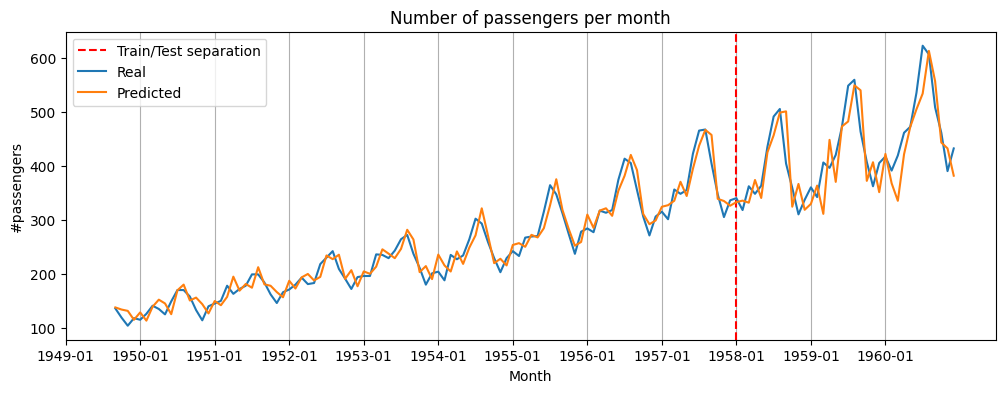

In [ ]:
def time_series_plot(train_predict):
    data_predict = train_predict.data
    y_data_plot = y.data

    # Denormalize
    data_predict = data_predict[0] * (td_max - td_min) + td_min
    y_data_plot = y_data_plot * (td_max - td_min) + td_min

    # Plotting
    plt.figure(figsize=(12, 4))
    plt.axvline(x=train_size, c="r", linestyle="--")
    # shifting the curve as first y-value not correspond first value overall
    plt.plot(seq_length + np.arange(y_data_plot.shape[0]), y_data_plot)################
    #plt.plot(np.arange(y_data_plot.shape[0]), y_data_plot)################
    plt.plot(seq_length + np.arange(y_data_plot.shape[0]), data_predict)

    plt.title("Number of passengers per month")
    plt.ylabel("#passengers")
    plt.xlabel("Month")
    plt.xticks(labels_to_display, dataset["Month"][labels_to_display])

    plt.legend(["Train/Test separation", "Real", "Predicted"])
    plt.grid(axis="x")
    plt.show()


rnn.eval()
train_predict, h = rnn(x)
time_series_plot(train_predict)

Видим, что модель в принципе справляется с задачей. Если подбирать размер hidden size, качество станет лучше. Или мы добьёмся того, что нейросеть будет предсказывать просто линию (большой hidden size — нейросеть выучивает, что нужно предсказывать следующее значение по предыщущему).

Но посмотрим, как далее справятся более мощные архитектуры, и уже позднее напишем окончательные выводы.



### Проблемы RNN

Теоретически, можно было бы сразу пропустить все данные через сеть и затем вычислить градиент, однако возникнут следующие проблемы:

 - большие последовательности не поместятся в памяти;
 - так как цепочка будет очень длинной, возникнет затухание/взрыв градиента;
 - по мере прохождения сигнала по цепи контекст затирается.


Допустим, у нас есть длинная последовательность. Если мы сразу предсказываем, то в каждый момент времени нужно распространить Loss. И все ячейки нужно обновить во время backpropogation. Все градиенты нужно посчитать. Возникают проблемы, связанные с нехваткой памяти.

Есть специальные тесты для проверки, контекст какой длины использует RNN при предсказании. Если мы делаем предсказание только в последней ячейке, может оказаться, что используется, скажем, информация только о последних 10 словах предложения.

Функция активации Tanh постепенно затирает контекст.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L09/backprop_through_time.png"><center>

<center><em>Source: <a href="http://cs231n.stanford.edu/slides/2021/lecture_10.pdf">CS231n: Recurrent Neural Network</a></em></center>

Затухающий/взрывающийся градиент (Vanishing/exploding gradient) — явления затухающего и взрывающегося градиента часто встречаются в контексте RNN. И при большой длине последовательности это становится критичным. Причина в том, что зависимость величины градиента от числа слоёв экспоненциальная, поскольку веса умножаются многократно.

$dL ∝ (W)^N$.

$W > 1$ => взрыв

$W < 1$ => затухание

<img src ="http://edunet.kea.su/repo/EduNet-content/dev-2.0/L09/out/simple_rnn_backprop.png">

Один из путей решения проблемы — **градиентное отсечение** (Gradient clipping) — метод, который ограничивает максимально допустимое значение градиента, позволяя избежать градиентного взрыва.

А от затухания градиента может помочь **пропускание** **градиента по частям**, на сколько-то шагов по времени назад или вперёд, а не через всю нейросеть. Да, градиент будет не совсем точно считаться, и мы будем терять в качестве. Но это нам спасает память.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L09/truncated_backprop.png"></center>

<center><em>Source: <a href="http://cs231n.stanford.edu/slides/2021/lecture_10.pdf">CS231n: Recurrent Neural Network</a></em></center>

# LSTM



Обычная RNN имела множество проблем, в том числе в ней очень быстро затухала информация о предыдущих словах в предложении. Помимо этого были проблемы с затуханием/взрывом самого градиента.

Эти проблемы были частично решены в LSTM, предложенной в [Long Short-Term Memory (Hochreiter & Schmidhuber, 1997) 📚[article]](http://www.bioinf.jku.at/publications/older/2604.pdf)

В обычной RNN в ячейке был только один путь передачи информации. На каждом шаге мы сливали информацию, накопленную с предыдущих шагов, с текущей:

<img src = "https://edunet.kea.su/repo/EduNet-content/dev-2.0/L09/out/simple_rnn_h_state.png" width="700">

При этом информация о предыдущих токенах очень быстро затухает, и теряется общая информация о предложении.

Структура ячейки LSTM намного сложнее. Здесь есть целых 4 линейных слоя, каждый из которых выполняет разные задачи.

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L09/out/lstm_chain.png" width="700">

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L09/out/lstm_chain_notation.png" width="700">

$\large f_t = σ(W_f \cdot [h_{t-1}, x_t] + b_f) - \text{forget  gate}$

$\large i_t = σ(W_i \cdot [h_{t-1}, x_t] + b_i) - \text{input gate}$

$\large C^\prime_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_{C^\prime}) - \text{candidate cell state}$

$\large C_t = f_t\otimes C_{t-1} + i_t \otimes C^\prime_t - \text{cell state}$

$\large o_t = σ(W_o \cdot [h_{t-1}, x_t] + b_o) - \text{output gate}$

$\large h_t = o_t\otimes \tanh(C_t) - \text{ block output}$


Главное нововведение: в LSTM добавлен путь $c$, который по задумке должен этот общий контекст сохранять.

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L09/out/lstm_c_state_highway.png" width="500">

Другими словами, путь $c$ (cell state, иногда называется highway, магистраль)  помогает нейросети сохранять важную информацию, встретившуюся в какой-то момент в предложении, все время, пока эта информация требуется.

По формулам также видно, как возросла сложность.

## LSTMCell

[[doc] 🛠️ LSTMCell в PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html)

Интерфейс отличается от RNNCell количеством входов и выходов.

In [ ]:
import torch

lstm_cell = torch.nn.LSTMCell(input_size=3, hidden_size=4)
input = torch.randn(1, 3)  # batch, input_size
h_0 = torch.randn(1, 4)
c_0 = torch.randn(1, 4)
h, c = lstm_cell(input, (h_0, c_0))  # second arg is tuple
print("Shape of h:", h.shape)  # batch, hidden_size
print("Shape of c:", c.shape)  # batch, hidden_size

Shape of h: torch.Size([1, 4])
Shape of c: torch.Size([1, 4])


## LSTM в PyTorch

Отличие от RNN состоит в том, что кроме $h$ возвращается еще и $c$.

In [ ]:
import torch.nn as nn

lstm = nn.LSTM(input_size=4, hidden_size=5)
input = torch.randn(3, 2, 4)  # seq_len, batch, input_size
out, (h, c) = lstm(input)  # h and c returned in tuple

print("Input shape:".ljust(15), input.shape)
print("Shape of h".ljust(15), h.shape)  # batch, hidden_size
print("Shape of c".ljust(15), c.shape)  # batch, hidden_size
print(
    "Output shape:".ljust(15), out.shape
)  # seq_len, batch, hidden_size : h for each element

Input shape:    torch.Size([3, 2, 4])
Shape of h      torch.Size([1, 2, 5])
Shape of c      torch.Size([1, 2, 5])
Output shape:   torch.Size([3, 2, 5])


**Замечания**

1. Сложность нейронной сети должна соответствовать сложности подаваемых в нее данных. С ростом ансамбля и числа нейронов увеличивается заучивание тренировочной выборки и теряется способность к обобщению.
2. Предварительный анализ цикличности в данных (если она есть) помогает понять оптимальный размер ансамбля (тут видно, что цикл в среднем составляет 8 интервалов).
3. Также результат может зависеть от типа масштабирования, который Вы применяете. Нужно знать принципы работы scaler'ов и не стесняться экспериментировать с ними:
 * [[blog] ✏️ Feature Scaling Data with Scikit-Learn for Machine Learning in Python](https://stackabuse.com/feature-scaling-data-with-scikit-learn-for-machine-learning-in-python/)
 * [[blog] ✏️ Hands-On Machine Learning with Scikit-Learn and TensorFlow, ч.4](https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/ch04.html)
4. При всей выгодности применения нейронных сетей, необходимо быть осторожным с автокорреляцией:
 * [[arxiv] 🎓 How to avoid machine learning pitfalls:
a guide for academic researchers (Lones, 2023)](https://arxiv.org/pdf/2108.02497.pdf)

###Пример

Давайте сразу посмотрим, как эта идея реализуется на практике. Далее в лекции подробно разберём работу отдельных блоков.

Сгенерируем 30 различных синусоид с одинаковой частотой и амплитудой, но начинающиеся немного с разных точек на оси Х.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

N = 30 # number of samples
L = 300 # length of each sample (number of values for each sine wave)
T = 10 # width of the wave
x = np.empty((N,L), np.float32) # instantiate empty array
x[:] = np.arange(L) + np.random.randint(-4*T, 4*T, N).reshape(N,1)
y = np.sin(x/1.0/T).astype(np.float32)

Сеть будет обучаться на 10 различных синусоидах.

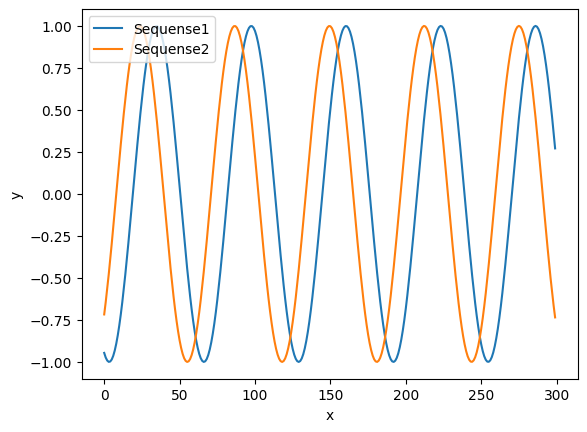

In [ ]:
plt.plot(y[0], label="Sequense1")
plt.plot(y[1], label="Sequense2")

plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")

plt.show()

Создадим класс модели и пройдёмся по его частям.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTM(nn.Module):
    def __init__(self, hidden_layers=512):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)

    def forward(self, y, future_preds=0):
        outputs, n_samples = [], y.size(0)
        h_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)

        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)

        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        # transform list to tensor
        outputs = torch.cat(outputs, dim=1)
        return outputs

Инициализация:

* `time_step` — количество признаков, описывающих входящий объект $x$,
* `hidden_layers` — размер вектора контекста $h$.

Мы определяем два слоя RNN, используя две ячейки RNNCell.  В первую ячейку RNN мы подаём входные данные размером $1$.

В RNN нам не нужно передавать нарезанный массив входных данных. Нам не нужно скользящее окно для данных, поскольку вектора контекста обеспечивают сохранение состояния ячейки за нас.

* `h_0` — тензор, содержащий начальное скрытое состояние для каждого элемента в кортеже размера `(batch, hidden_size).`

Размер батча равен $30$, это определяется первым измерением входных данных, следовательно, берем `n_samples = x.size(0)`.

Следующий шаг, пожалуй, самый трудный. Мы должны подать тензор соответствующей формы. Это будет тензор из m точек, где m — размер `train` в каждой последовательности.

In [ ]:
a = torch.from_numpy(y[3:, :-1])
b = a.split(1, dim=1)
b[0].shape

torch.Size([27, 1])

Ещё один момент: мы обрабатываем $1$ элемент в строке, и, чтобы предсказать $300$-й элемент (и посчитать ошибку), мы должны остановиться на $299$-м. То же самое касается начала последовательности. По первому элементу предсказываем второй.

In [ ]:
train_input = torch.from_numpy(y[3:, :-1]) # (27, 299)
train_target = torch.from_numpy(y[3:, 1:]) # (27, 299)
test_input = torch.from_numpy(y[:3, :-1]) # (3, 299)
test_target = torch.from_numpy(y[:3, 1:]) # (3, 299)

Цикл обучения приближен к стандартному.

Добавлена функция отрисовки предсказываемых синусоид для визуализации сходимости.

In [ ]:
def draw(yi, n, i, future):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12,3))

    plt.title(f"Step {i+1}")
    plt.xlabel("x")
    plt.ylabel("y")

    ax1.plot(np.arange(n), yi[0][:n], 'r', linewidth=2.0)
    ax1.plot(np.arange(n, n+future), yi[0][n:], 'r'+":", linewidth=2.0)

    ax2.plot(np.arange(n), yi[1][:n], 'g', linewidth=2.0)
    ax2.plot(np.arange(n, n+future), yi[1][n:], 'g'+":", linewidth=2.0)

    ax3.plot(np.arange(n), yi[2][:n], 'b', linewidth=2.0)
    ax3.plot(np.arange(n, n+future), yi[2][n:], 'b'+":", linewidth=2.0)

    plt.savefig("predict%d.png"%i, dpi=200)
    plt.show()
    plt.close()

def training_loop(n_epochs, model, optimiser, loss_fn,
                  train_input, train_target, test_input, test_target):
    for i in range(n_epochs):
        def closure():
            optimiser.zero_grad()
            out = model(train_input)
            loss = loss_fn(out, train_target)
            loss.backward()
            return loss
        optimiser.step(closure)
        with torch.no_grad():
            future = 100
            pred = model(test_input, future_preds=future)
            # use all pred samples, but only go to 299
            loss = loss_fn(pred[:, :-future], test_target)
            y = pred.detach().numpy()
        # draw figures
        n = train_input.shape[1] # 299
        draw(y, n, i, future)

        # print the loss
        out = model(train_input)
        loss_print = loss_fn(out, train_target)
        print("Step: {}, Loss: {}".format(i, loss_print))

In [ ]:
# для замороченных данных вспомни о использованном здесь оптимизаторе

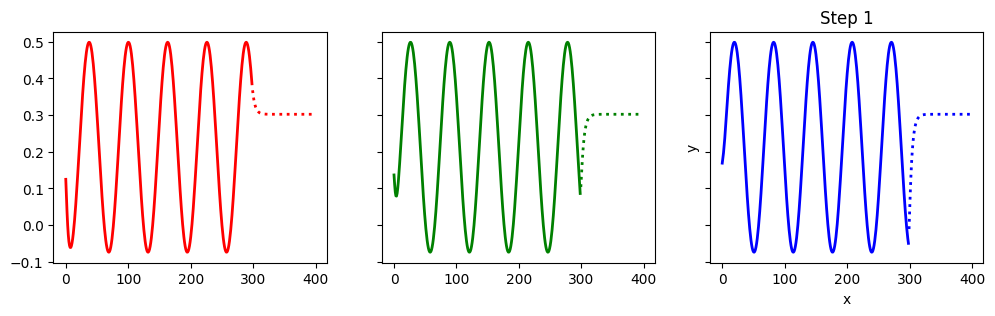

Step: 0, Loss: 0.3206043243408203


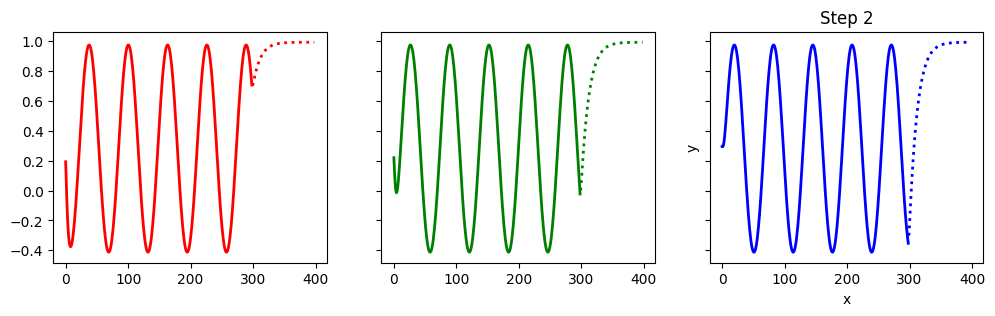

Step: 1, Loss: 0.17632746696472168


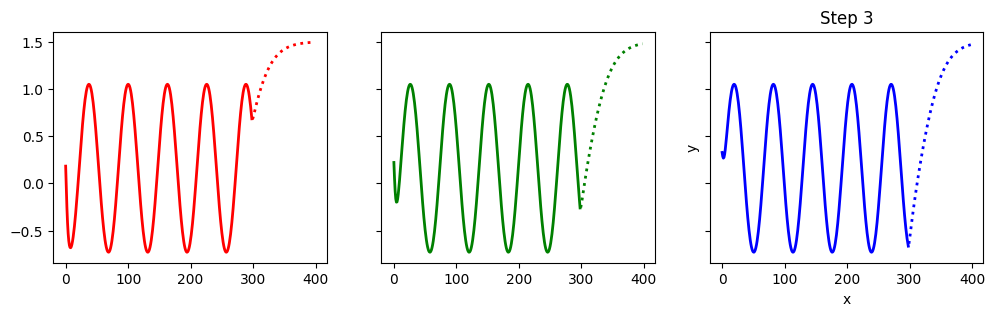

Step: 2, Loss: 0.08680156618356705


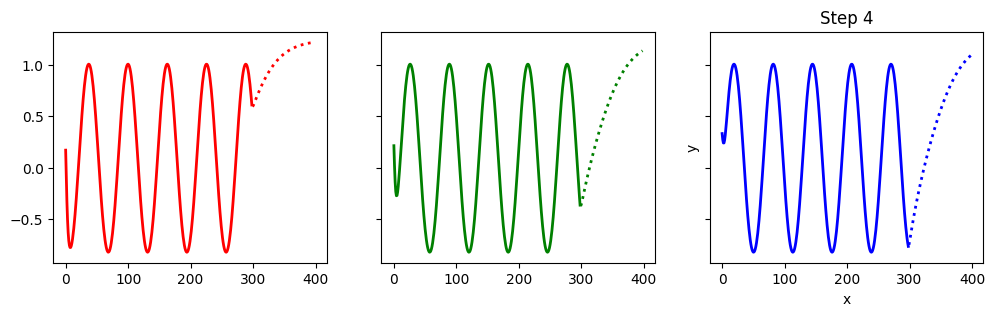

Step: 3, Loss: 0.06137474998831749


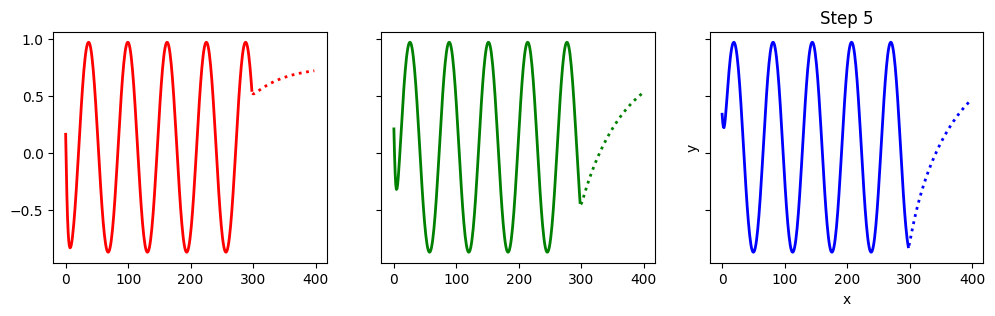

Step: 4, Loss: 0.047354795038700104


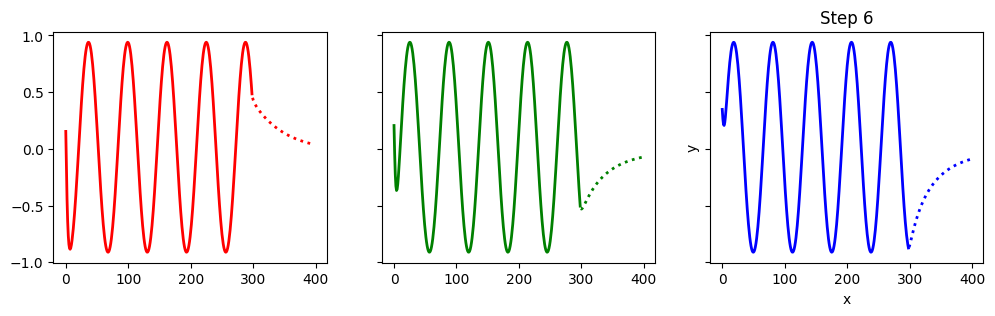

Step: 5, Loss: 0.0361202098429203


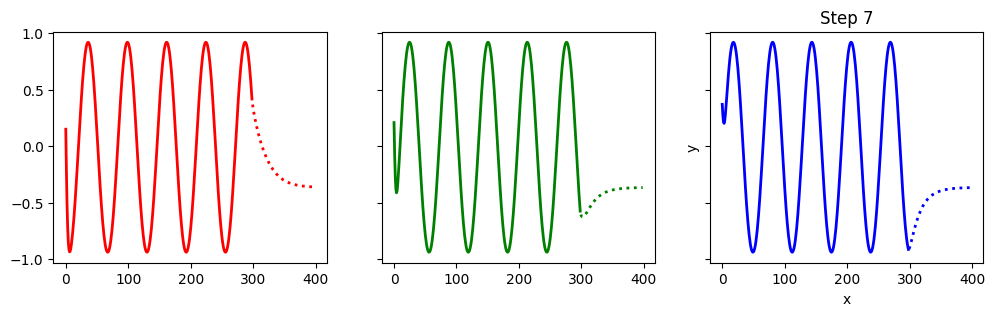

Step: 6, Loss: 0.02473856322467327


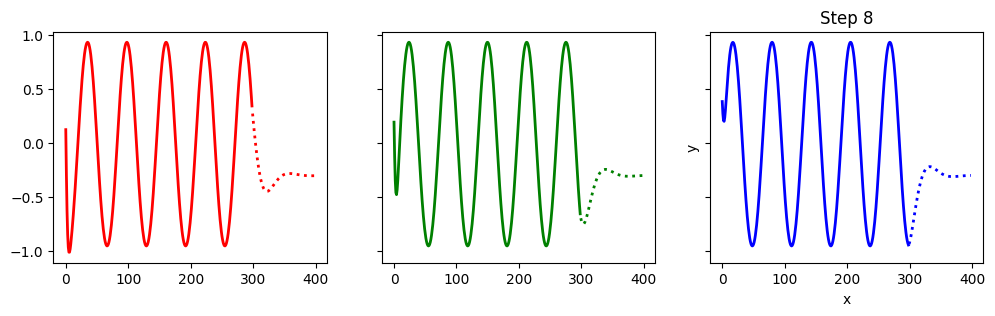

Step: 7, Loss: 0.01056146901100874


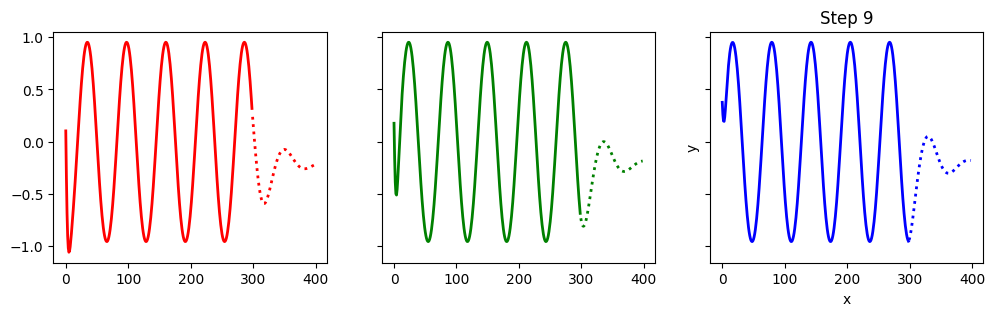

Step: 8, Loss: 0.006131290458142757


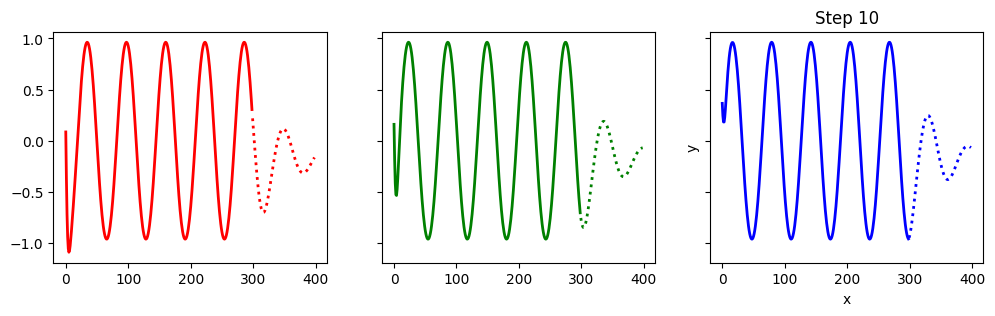

Step: 9, Loss: 0.004495843779295683


In [ ]:
model = LSTM()
criterion = nn.MSELoss()
optimiser = optim.LBFGS(model.parameters(), lr=0.01)
#optimiser = optim.AdamW(model.parameters(), lr=0.01)

n_epochs = 10

training_loop(
              n_epochs,
              model,
              optimiser,
              criterion,
              train_input,
              train_target,
              test_input,
              test_target)

In [ ]:
del(model)
del(optimiser)

### Bidirectional

Хорошо бы ещё как-то улучшить обучение модели.

<center><img src ="http://edunet.kea.su/repo/EduNet-content/dev-2.0/L09/out/signal.png" width="700"></center>

Последовательность можно пропустить через сеть два раза: в прямом и обратном направлении. Для этого создаётся слой, аналогичный входному, для обратного направления, и результат двух слоёв конкатенируется.

[[blog] ✏️ A Beginner’s Guide on Recurrent Neural Networks with PyTorch](https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/)

<center><img src ="http://edunet.kea.su/repo/EduNet-content/dev-2.0/L09/out/bidirectional.png" width="700"></center>

In [ ]:
dummy_input = torch.randn((2, 1, 3))  # seq_len, batch, input_size
rnn = torch.nn.RNN(3, 2, bidirectional=True)

for t, p in rnn.named_parameters():
    print(t, p.shape)

out, h = rnn(dummy_input)

print()
print("Out:\n", out.shape)  # Concatenated Hidden states from both layers
print(
    "h:\n", h.shape
)  # Hidden states last element from  both : 2*num_layers*hidden_state

weight_ih_l0 torch.Size([2, 3])
weight_hh_l0 torch.Size([2, 2])
bias_ih_l0 torch.Size([2])
bias_hh_l0 torch.Size([2])
weight_ih_l0_reverse torch.Size([2, 3])
weight_hh_l0_reverse torch.Size([2, 2])
bias_ih_l0_reverse torch.Size([2])
bias_hh_l0_reverse torch.Size([2])

Out:
 torch.Size([2, 1, 4])
h:
 torch.Size([2, 1, 2])


### Скрытое состояние

Как вы уже могли отметить, RNN ячейку можно инициализировать собственным начальным вектором. А затем подавать туда скрытое состояние на каждой итерации. **Или не подавать.**

Как так-то?

Да, цель скрытого состояния — закодировать историю. Допустим, ваши входные данные представляют собой последовательность данных со 2 по 11 день, и закодированная история в скрытом состоянии связана только с данными со 2 по 11 день. Таким образом, ваши батчи должны содержать всю историю, необходимую для каждого выходного прогноза.

При этом **обязательно** нужно **сбросить** скрытое состояние между батчами, если данные в них независимы. Вы не хотите, чтобы ваше скрытое состояние из вашего прошлого предсказания повлияло на следующее?

[[blog] ✏️ Обсуждение на Stackexchange](https://stats.stackexchange.com/questions/470382/what-is-the-use-of-the-hidden-state-in-an-lstm-network)

## Модификации LSTM

**GRU (Gated reccurent unit)**

Самая известная модификация LSTM — GRU. Она более компактна за счет сильных упрощений в сравнении со стандартной LSTM.

Главные изменения: объединены forget и input gates, слиты $h_t$ и $C_t$, которые в обычной LSTM только участвовали в формировании друг друга.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L09/out/gru_basic_block.png" width="500">

$\large z_t = \sigma(W_z \cdot [h_{t-1}, x_t])$

$\large r_t = \sigma(W_r \cdot [h_{t-1}, x_t])$

$\large \tilde h_t = tanh(W \cdot [r_t * h_{t-1}, x_t])$

$\large h_t = (1-z_t) * h_{t-1} + z_t * \tilde h_t$

In [ ]:
gru = torch.nn.GRU(input_size=4, hidden_size=3)
input = torch.randn(2, 1, 4)  # seq_len, batch, input_size
h0 = torch.randn(1, 1, 3)
output, h = gru(input, h0)

print("Input shape:".ljust(15), input.shape)
print("Shape of h:".ljust(15), h.shape)  # last h
print("Output shape:".ljust(15), output.shape)  # seq_len = 2

Input shape:    torch.Size([2, 1, 4])
Shape of h:     torch.Size([1, 1, 3])
Output shape:   torch.Size([2, 1, 3])


Практический опыт исследователей: иногда лучше работает GRU, иногда — LSTM. Точный рецепт успеха сказать нельзя.

#Типы задач

Рекуррентная сеть может выдавать некий ответ на каждом шаге, однако мы можем:

 1. Использовать только выданный на последнем (если нам нужно предсказать одно значение) — **many-to-one**.

 2. Подавать в нейросеть токены (когда кончился исходный сигнал, подаем нулевые токены), пока она не сгенерирует токен, символизирующий остановку (**many-to-many, one-to-many**).

 3. Делать различные комбинации, игнорируя часть выходов нейросети в начале её работы.

*   **«One to one»** — обычная нейронная сеть, не обязательно применять RNN в таком случае.

*   Более сложной является реализация **«one to many»**, когда у нас есть всего один вход, и нам необходимо сформировать несколько выходов. Такой тип нейронной сети актуален, когда мы говорим о **генерации музыки** или **текстов**. Мы задаем начальное слово или начальный звук, а дальше модель начинает самостоятельно генерировать выходы, в качестве входа к очередной ячейке рассматривая выход с прошлой ячейки нейронной сети.

*   Если мы рассматриваем задачу **классификации**, то актуальна схема **«many to one»**. Мы должны проанализировать все входы нейронной сети и только в конце определиться с классом.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L09/out/one_or_many_to_one_or_many_ways_1.png" width="8000"></center>

*   Схема **«many to many»**, в которой количество выходов **равно** количеству входов нейронной сети. Обычно это задачи типа разметки исходной последовательности. Например, указать столицы городов, названия важных объектов, веществ и т.д., что относится к задачам вида NER (Named entity recogition).

*   Схема **«many to many»**, в которой количество выходов нейронной сети **не равно** количеству входов. Это актуально в машинном переводе, когда одна и та же фраза может иметь разное количество слов в разных языках (т.е. это реализует схему кодировщик-декодировщик). Кодировщик получает данные различной длины — например, предложение на английском языке. С помощью скрытых состояний он формирует из исходных данных вектор, который затем передаётся в декодировщик. Последний, в свою очередь, генерирует из полученного вектора выходные данные — исходную фразу, переведённую на другой язык.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L09/out/one_or_many_to_one_or_many_ways_2.png" width="800"></center>

Можно объединять разные подходы. Сначала генерируем некий $h$, который содержит сжатую информацию о том, что было подано в нейросеть, а затем подаем его в нейросеть «one to many», которая генерирует, к примеру, перевод того текста, что был подан первой части нейросети.

Среди NLP-задач можно выделить такие группы:


<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L09/out/nlp_tasks.png" width="800"></center>

В зависимости от источника ввода полученный текст может иметь свои особенности. Автоматическое распознавание приводит к ошибкам распознавания и разметки страниц; текст из социальных сетей — большое количество сокращений, смайлов, хэштегов, упоминаний и пр.

# Пример посимвольной генерации текста

[[git] 🐾 RNN-walkthrough](https://github.com/gabrielloye/RNN-walkthrough/blob/master/main.ipynb)

Начнем с относительно простой задачи — посимвольной генерации текста. Как правило, конвейер обработки текста содержит в себе следующие 5 блоков. К ним, в зависимости от задачи, добавляются дополнительные пункты.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L09/out/base_nlp_pipeline.png" width="700"></center>

**Постановка задачи:** предсказать следующий символ в последовательности.

- исходный текст:
'hey how are you'

- искаженный текст:
'hey how are yo'

- Верное предсказание:
'u'

Очень похоже на то, что мы делали ранее с временными рядами. Инференс модели будет выглядеть так:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L09/character_by_character_generation_example.gif" width="400">

<em>Source: <a href="http://karpathy.github.io/2015/05/21/rnn-effectiveness/">The Unreasonable Effectiveness of Recurrent Neural Networks</a></em>

## Подготовка данных

В нашей учебной задаче мы сократим до минимума выполняемые операции по подготовке данных для модели.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L09/out/simple_pipeline.png" width="700"></center>

In [ ]:
import pprint

text = ["hey how are you", "good i am fine", "have a nice day"]

# Join all the sentences together and extract the unique characters
# from the combined sentences
chars = set("".join(text))
# Creating a dictionary that maps integers to the characters
int2char = dict(enumerate(chars))
# Creating another dictionary that maps characters to integers
char2int = {char: ind for ind, char in int2char.items()}

print("Dictionary for mapping character to the integer:")
pprint.pprint(char2int)

Dictionary for mapping character to the integer:
{' ': 8,
 'a': 5,
 'c': 9,
 'd': 12,
 'e': 16,
 'f': 7,
 'g': 6,
 'h': 3,
 'i': 14,
 'm': 0,
 'n': 15,
 'o': 11,
 'r': 13,
 'u': 1,
 'v': 10,
 'w': 4,
 'y': 2}


Вместо ASCII символа, каждой букве мы сопоставили номер.

### Выравнивание данных (Padding)

RNN допускают работу с данными переменной длины. Но чтобы поместить предложения в batch, надо их выровнять.

Обычно размер батча делают равным самому длинному предложению, а остальные просто дополняют пробелами (или спецсимволами) до этого размера.  Также хорошей идеей будет отметить специальным символом начало предложения.

In [ ]:
lengths = [len(sent) for sent in text]
maxlen = max(lengths)
print(f"The longest string has {maxlen} characters.\n")

print(f"Initial texts:\n{text}")
# A simple loop that loops through the list of sentences and adds
# a ' ' whitespace until the length of the sentence matches
# the length of the longest sentence
for i in range(len(text)):
    while len(text[i]) < maxlen:
        text[i] += " "

print(f"Resulting texts:\n{text}")

The longest string has 15 characters.

Initial texts:
['hey how are you', 'good i am fine', 'have a nice day']
Resulting texts:
['hey how are you', 'good i am fine ', 'have a nice day']


### Разбиение данных

В качестве входа будем использовать предложение без последнего символа:

**'hey how are yo'**

В качестве результата — предложение, в котором он сгенерирован:

**'ey how are you'**

In [ ]:
# Creating lists that will hold our input and target sequences
input_seq = []
target_seq = []

for i in range(len(text)):
    # Remove last character for input sequence
    input_seq.append(text[i][:-1])

    # Remove first character for target sequence
    target_seq.append(text[i][1:])

    print("Input sequence:".ljust(18), f"'{input_seq[i]}'")
    print("Target sequence:".ljust(18), f"'{target_seq[i]}'")
    print()

Input sequence:    'hey how are yo'
Target sequence:   'ey how are you'

Input sequence:    'good i am fine'
Target sequence:   'ood i am fine '

Input sequence:    'have a nice da'
Target sequence:   'ave a nice day'



### Кодирование

Теперь символы надо перевести в числа. Для этого мы уже построили словарь.

P.S. Запускать блок только один раз.

In [ ]:
for i in range(len(text)):
    input_seq[i] = [char2int[character] for character in input_seq[i]]
    target_seq[i] = [char2int[character] for character in target_seq[i]]

    print("Encoded input sequence:".ljust(25), input_seq[i])
    print("Encoded target sequence:".ljust(25), target_seq[i])
    print()

Encoded input sequence:   [3, 16, 2, 8, 3, 11, 4, 8, 5, 13, 16, 8, 2, 11]
Encoded target sequence:  [16, 2, 8, 3, 11, 4, 8, 5, 13, 16, 8, 2, 11, 1]

Encoded input sequence:   [6, 11, 11, 12, 8, 14, 8, 5, 0, 8, 7, 14, 15, 16]
Encoded target sequence:  [11, 11, 12, 8, 14, 8, 5, 0, 8, 7, 14, 15, 16, 8]

Encoded input sequence:   [3, 5, 10, 16, 8, 5, 8, 15, 14, 9, 16, 8, 12, 5]
Encoded target sequence:  [5, 10, 16, 8, 5, 8, 15, 14, 9, 16, 8, 12, 5, 2]



#### One-hot encoding

Теперь из чисел надо сделать вектора.

Причина — подача чисел даст модели ложное знание об отношениях между объектами по типу "*буква а в два раза больше буквы б*". Нам же нужно равномерно распределить наши представления в некотором пространстве.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L09/out/one_hot_encoding_softmax.png" width="250">

In [ ]:
import numpy as np

dict_size = len(char2int)
seq_len = maxlen - 1
batch_size = len(text)


def one_hot_encode(sequence, dict_size, seq_len, batch_size):
    # Creating a multi-dimensional array of zeros with the desired output shape
    features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float32)

    # Replacing the 0 at the relevant character index with a 1 to represent that character
    for i in range(batch_size):
        for u in range(seq_len):
            features[i, u, sequence[i][u]] = 1
    return features


input_seq = one_hot_encode(input_seq, dict_size, seq_len, batch_size)
print(
    "Input shape: {} --> (Batch Size, Sequence Length, One-Hot Encoding Size)".format(
        input_seq.shape
    )
)
print(input_seq[0])

Input shape: (3, 14, 17) --> (Batch Size, Sequence Length, One-Hot Encoding Size)
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


Каждый символ закодировали вектором.
Не слишком экономно, зато удобно умножать на матрицу весов.

**Пример: Language Modeling**

Кодируем буквы при помощи **one-hot кодирования** и подаем на входной слой.

$\begin{bmatrix} w_{11} & w_{12} & w_{13} & w_{14} \\ w_{21} & w_{22} & w_{23} & w_{24} \\ w_{31} & w_{32} & w_{33} & w_{34} \end{bmatrix} \cdot \begin{bmatrix} 1 \\ 0\\ 0 \\ 0 \end{bmatrix} = \begin{bmatrix} w_{11} \\ w_{21} \\ w_{31}\end{bmatrix}$

Таким образом, обработка

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L09/out/language_modeling.png" width="550">

Умножение матрицы на one-hot представление просто достает соответствующую ненулевому значению колонку из матрицы весов.
Поэтому часто вместо написания двух отдельных слоев (one-hot + линейного) делают просто слой, называемый **Embedding Layer**.

In [ ]:
# Convert data to tensor
import torch

input_seq = torch.Tensor(input_seq)
target_seq = torch.Tensor(target_seq)

## Создание и обучение модели

In [ ]:
import torch.nn as nn


class NextCharacterGenerator(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super().__init__()

        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_size=hidden_dim, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        # Initializing hidden state for first input using method defined below
        hidden_0 = torch.zeros(
            1, batch_size, self.rnn.hidden_size
        )  # 1 correspond to number of layers

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden_0)

        # Reshaping the outputs such that it can be fit into the fully connected layer
        # Need Only if n_layers > 1
        out = out.contiguous().view(-1, self.rnn.hidden_size)
        out = self.fc(out)

        return out, hidden

### Обучение

In [ ]:
# Instantiate the model with hyperparameters
model = NextCharacterGenerator(
    input_size=dict_size, output_size=dict_size, hidden_dim=12, n_layers=1
)

# Define hyperparameters
num_epochs = 100

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training Run
for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()  # Clears existing gradients from previous epoch
    output, hidden = model(input_seq)
    loss = criterion(output, target_seq.view(-1).long())
    loss.backward()  # Does backpropagation and calculates gradients
    optimizer.step()  # Updates the weights accordingly

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}/{num_epochs}".ljust(20), end=" ")
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 10/100        Loss: 2.3789
Epoch: 20/100        Loss: 2.0754
Epoch: 30/100        Loss: 1.6627
Epoch: 40/100        Loss: 1.2588
Epoch: 50/100        Loss: 0.9021
Epoch: 60/100        Loss: 0.6100
Epoch: 70/100        Loss: 0.3978
Epoch: 80/100        Loss: 0.2654
Epoch: 90/100        Loss: 0.1865
Epoch: 100/100       Loss: 0.1401


### Тестирование

In [ ]:
def predict(model, character):
    # One-hot encoding our input to fit into the model
    character = np.array([[char2int[c] for c in character]])
    character = one_hot_encode(character, dict_size, character.shape[1], 1)
    character = torch.from_numpy(character)

    out, hidden = model(character)
    # print(out.shape)
    # print(out)
    prob = nn.functional.softmax(out[-1], dim=0).data
    # Taking the class with the highest probability score from the output
    char_ind = torch.max(prob, dim=0)[1].item()

    return int2char[char_ind], hidden


def sample(model, out_len, start="hey"):
    model.eval()  # eval mode
    start = start.lower()
    # First off, run through the starting characters
    chars = [ch for ch in start]
    size = out_len - len(chars)
    # Now pass in the previous characters and get a new one
    for _ in range(size):
        char, h = predict(model, chars)
        chars.append(char)

    return "".join(chars)


sample(model, 15, "good")

'good i am fine '

Попробуем сгенерировать несколько вариантов предложения.

In [ ]:
for _ in range(3):
    print(sample(model, 15, "good"))

good i am fine 
good i am fine 
good i am fine 


Так получается, потому что сеть инициализирована нулями и никакой случайности нет. Даже если мы добавим в датасет ещё предложение, начинающиеся с *good*, результат не изменится. Также сеть переобучилась на небольшом датасете.

# Представление данных

## Токенизация

Один из ключевых этапов в обработке текста — **токенизация**. На этом этапе происходит разделение текста на отдельные единицы — предложения и слова. Затем создается словарь, в который заносятся уникальные лексемы, встретившиеся в корпусе или тексте. На этих этапах можно столкнуться с несколькими проблемами.

**Проблема 1. Размер словаря**

Самый простой способ токенизации — назначить каждому уникальному слову своё число. Но есть проблема: слов и их форм миллионы, и поэтому словарь таких слов получится чересчур большим, а это будет затруднять обучение модели.

Можно разбивать текст не на слова, а на отдельные буквы (char-level tokenization), тогда в словаре будет всего несколько десятков токенов, НО в таком случае уже сам текст после токенизации будет слишком длинным, а это тоже затрудняет обучение.

**Проблема 2. Богатая морфология**

"Нейросеть", "сетка", "сеть" являются разными словами, но имеют схожий смысл. Эту проблему классически всегда решал этап **стемминга** (удаление суффикса, приставки, окончания) или **лемматизации** (приведение слова к канонической форме).

**Проблема 3. Сложные слова**

Но все проблемы эти этапы не решают. В германских языках (в английском, немецком, шведском и т.д.) очень продуктивно образовываются новые сложные слова. Значения таких слов выводятся из значения их элементов. Их можно создавать бесконечно долго, и большинство из них не зафиксировано в «бумажном» словаре.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L09/swedish_word_example.png" width="600"></center>

<center><em>Пример шведского названия гаечного ключа для колеса мотоцикла</a></em></center>

<center><em>Source: <a href="https://sysblok.ru/nlp/7250/">Как работает алгоритм токенизации текстов для нейросетей</a></em></center>

При работе с этими языками сложность также возникает на этапе составления словаря. При составлении словаря модели ориентируются на частотность (например, сохраняем слово, если оно встретилось чаще пяти раз), поэтому не будут запоминать такое длинное и сложное слово.

**Проблема 4: Границы слова**

Для нас, привыкших к языкам европейского типа, слово — это набор букв между пробелами и знаками препинания. Но в английском языке многие сложные слова пишутся раздельно, а в японском, наоборот, между словами вообще нет пробелов. Поэтому универсальный токенизатор создать было нелегко.

## TF-IDF

**TF-IDF** — способ численного представления документа, оценивает  **важность слова в контексте документа**. Состоит из двух множителей $\text{TF}$ и $\text{IDF}$.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L09/out/tf_idf.png" width="500"></center>




Первая идея **TF-IDF** — **если слово часто встречается в документе, оно важное**. За это отвечает $TF$.

$\text{TF}$ (term frequency) — частота вхождения слова в документ, для которого рассчитывается значение:

$$\large \text{TF}(t, d) = \frac{n_t}{\sum_{k}n_k},$$

$n_t$ — количество повторов слова $t$ в документе $d$,

$\sum_{k}n_k$ — общее количество слов  $t$ в документе $d$ с повторами.

Вторая идея **TF-IDF** — **если слово встречается во многих документах, его ценность снижается**.

Пример: местоимения встречаются в большинстве текстов, но не несут смысловой нагрузки.

За это отвечает $\text{IDF}$.

$\text{IDF}$ (inverse document frequency) — логарифм обратной частоты вхождения слова в документы.
$$\large \text{IDF}(t, D) = \log{\frac{|D|}{|\{d_i \in D| t_i \in d_i \}|}},$$

где $|D|$ — число документов в коллекции,
$|\{d_i \in D| t_i \in d_i \}|$ — число документов в коллекции со словом $t$.


Итоговая формула:
$$\large \text{TF-IDF}(t, d, D) = \text{TF}(t,d)⋅\text{IDF}(t, D)$$

Пример работы `TfidfVectorizer` из [sklearn 🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).
Каждому документу сопоставляется вектор, равный длине словаря. Ненулевые значения вектора хранятся в виде разреженных матриц `scipy.sparse.csr_matrix` [🛠️[doc]](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?",
]

vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(corpus)

print("Tf-idf dictionary:", vectorizer.get_feature_names_out())
print("Tf-idf dictionary len:", len(vectorizer.get_feature_names_out()))
print("Tf-idf shape:", x.shape)
print("Tf-idf type:", type(x))
print("Tf-idf values:", x)

Tf-idf dictionary: ['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']
Tf-idf dictionary len: 9
Tf-idf shape: (4, 9)
Tf-idf type: <class 'scipy.sparse._csr.csr_matrix'>
Tf-idf values:   (0, 1)	0.46979138557992045
  (0, 2)	0.5802858236844359
  (0, 6)	0.38408524091481483
  (0, 3)	0.38408524091481483
  (0, 8)	0.38408524091481483
  (1, 5)	0.5386476208856763
  (1, 1)	0.6876235979836938
  (1, 6)	0.281088674033753
  (1, 3)	0.281088674033753
  (1, 8)	0.281088674033753
  (2, 4)	0.511848512707169
  (2, 7)	0.511848512707169
  (2, 0)	0.511848512707169
  (2, 6)	0.267103787642168
  (2, 3)	0.267103787642168
  (2, 8)	0.267103787642168
  (3, 1)	0.46979138557992045
  (3, 2)	0.5802858236844359
  (3, 6)	0.38408524091481483
  (3, 3)	0.38408524091481483
  (3, 8)	0.38408524091481483


**На практике**

1. Тексты токенизируются и нормализуются. Если мы решаем работать с N-граммами, то вместо токенизации или после неё выделяем N-граммы.

2. Проходимся по всей коллекции документов и для каждого слова подсчитываем, в каком количестве документов оно встретилось. Если у нас большая коллекция, то словарь может получиться просто гигантским, особенно если мы работаем с N-граммами, поэтому периодически, во время построения или после этой процедуры, мы должны выбросить из словаря всё, что считаем неинформативным — слишком редкие и слишком частые слова.

3. Затем начинаем строить матрицу признаков. Каждая строчка этой матрицы соответствует документу, а каждый столбец — статистике встречаемости этого слова в документе. Таким образом, для каждого документа мы считаем частоты слов в нём и записываем в соответствующие ячейки таблицы веса слов по указанной формуле.

4. Переходим к следующему документу.

Таким образом, TF-IDF — это способ взвешивания и отбора категориальных признаков в задачах машинного обучения — не только в классификации и не только для текстов. Надо заметить, что TF-IDF никак не использует информацию о метке объекта — это одновременно и преимущество, и недостаток. Преимущество заключается в том, что мы можем использовать TF-IDF, не имея меток, то есть задачах обучения без учителя. Недостаток — в том, что мы теряем информацию или недостаточно эффективно её используем.

[[wiki] 📚 TF-IDF](https://ru.wikipedia.org/wiki/TF-IDF)

[[doc] 🛠️ sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

[[doc] 🛠️ Ещё несколько способов взвешивания и отбора признаков](https://scikit-learn.org/stable/modules/feature_selection.html)

[[doc] 🛠️ TF-IDF Vectorizer scikit-learn](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting)

**Когда TF-IDF может быть неэффективен:**

1. **Отсутствие семантической информации**: TF-IDF не учитывает семантические связи между словами, что может привести к ограниченной способности понимания смысла текста.

2. **Чувствительность к длине** документа: длинные документы могут иметь более высокие значения TF, даже если ключевые слова встречаются реже. В таких случаях TF-IDF может недооценить важность конкретных слов.

## Word2Vec

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L09/w2v_example.png" width="400"></center>

<center><em>Source: <a href="https://habr.com/ru/articles/585838/">Семантика и технология Word2Vec</a></em></center>



Word2Vec — нейронная сеть из двух слоев, которая обрабатывает текст, преобразуя его в числовые “векторизованные” слова. Входные данные w2v — это громадный текстовый корпус, из которого на выходе мы получаем пространство векторов (линейное пространство), размерность которого обычно достигает сотен, где каждое уникальное слово в корпусе представлено вектором из сгенерированного пространства.

Мы учим сеть так, что вектора, соответствующие похожим словам, располагаются близко в новом пространстве,  и над ними работают векторные операции.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L09/w2v_example_2.png" width="500"></center>

<center><em>Source: <a href="https://habr.com/ru/articles/446530/">Word2vec в картинках</a></em></center>


Такие операции не приводят к точному соответствию, однако получаемые вектора оказываются самыми похожими.

[[colab] 🥨 Подробное руководство по использованию Word2Vec](https://colab.research.google.com/drive/1OJF0k-E60sp9Vyoj1yWuoedGTrwRiTyj?usp=sharing)

## Слой эмбеддингов

Ранее мы применяли OneHotEncoding для представления наших слов. Проблемы возникают, когда пространство объектов начинает расти и у нас возникают огромные разреженные матрицы.

Кроме того, некоторые объекты у нас сразу могут быть ближе: семантически "король" и "королева" отличаются только полом, различие между словами "король" и "стул" заметно выше.

Поэтому мы можем переводить наши слова в вектора меньшей размерности, которые при этом будут сравнимы между собой с помощью модуля `nn.Embedding` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html).

[[doc] 🛠️ Туториал PyTorch по применению эмбедингов в NLP](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html)

[[blog] ✏️ NLP Course for you](https://lena-voita.github.io/nlp_course.html)

[[git] 🐾 Курс по NLP от ШАД](https://github.com/yandexdataschool/nlp_course)

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L09/word_representation_intro_min.png" width="600">

____

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L09/lookup_table.gif" width="600">

<em>Source: <a href="https://lena-voita.github.io/nlp_course/word_embeddings.html">Lena Voita NLP Course</a></em>

In [ ]:
# Let's say you have 2 sentences (lowercased, punctuations removed):
sentences = "i am new to pytorch i am having fun"

words = sentences.split(" ")

print(f"All words: {words} \n")

vocab = set(words)  # create a vocabulary
vocab_size = len(vocab)

print(f"Vocabulary (unique words): {vocab} \n")
print(f"Vocabulary size: {vocab_size} \n")

# map words to unique indices
word2idx = {word: ind for ind, word in enumerate(vocab)}

print(f"Word-to-id dictionary: {word2idx} \n")

encoded_sentences = [word2idx[word] for word in words]

print(f"Encoded sentences: {encoded_sentences}")

# let's say you want embedding dimension to be 3
emb_dim = 3

All words: ['i', 'am', 'new', 'to', 'pytorch', 'i', 'am', 'having', 'fun'] 

Vocabulary (unique words): {'new', 'pytorch', 'am', 'having', 'fun', 'i', 'to'} 

Vocabulary size: 7 

Word-to-id dictionary: {'new': 0, 'pytorch': 1, 'am': 2, 'having': 3, 'fun': 4, 'i': 5, 'to': 6} 

Encoded sentences: [5, 2, 0, 6, 1, 5, 2, 3, 4]


Теперь нейросетевой слой эмбеддингов может быть определён так:

In [ ]:
import torch
import torch.nn as nn


emb_layer = nn.Embedding(vocab_size, emb_dim)

word_vectors = emb_layer(torch.LongTensor(encoded_sentences))

print(f"Shape of encoded sentences: {word_vectors.shape} \n")

print(f"Shape of weigths: {emb_layer.weight.shape}")

Shape of encoded sentences: torch.Size([9, 3]) 

Shape of weigths: torch.Size([7, 3])


Этот код инициализирует эмбеддинги согласно нормальному распределению (со средним значением 0 и дисперсией 1). Таким образом, пока что никакого различия или сходства между векторами нет.

`word_vectors` — тензор размером (9, 3). 9 слов в датасете, размер 3 задан нами.

`emb_layer` имеет 1 обучаемый параметр `weight`, который по умолчанию True. Можем проверить так:

In [ ]:
emb_layer.weight.requires_grad

True

Если мы не хотим обучать этой слой (например, используем заранее обученные эмбеддинги), мы можем заморозить его веса:

In [ ]:
emb_layer.weight.requires_grad = False

Если мы хотим использовать заранее определённые веса:

In [ ]:
# predefined weights
weight = torch.FloatTensor([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6]])
print(weight.shape)
embedding = nn.Embedding.from_pretrained(weight)
# get embeddings for ind 0 and 1
embedding(torch.LongTensor([0, 1]))

torch.Size([2, 3])


tensor([[0.1000, 0.2000, 0.3000],
        [0.4000, 0.5000, 0.6000]])

Скачаем уже готовые веса модели Word2Vec, обученные на датасете Google News, состоящeм из 100 миллиардов слов:

In [ ]:
# Use this way for fast loading from Google Drive
!gdown "1ooLZnU8J54YzHtG5xXb3iDnY_TwIOY2K"

# Use this way for loading from our host
# !wget https://edunet.kea.su/repo/EduNet-web_dependencies/weights/GoogleNews-vectors-negative300.bin.gz

!gunzip -q GoogleNews-vectors-negative300.bin.gz

Downloading...
From: https://drive.google.com/uc?id=1ooLZnU8J54YzHtG5xXb3iDnY_TwIOY2K
To: /content/GoogleNews-vectors-negative300.bin.gz
100% 1.65G/1.65G [01:00<00:00, 27.3MB/s]


In [ ]:
from gensim.models import KeyedVectors

wordvector_path = "GoogleNews-vectors-negative300.bin"
word_vectors = KeyedVectors.load_word2vec_format(wordvector_path, binary=True)

In [ ]:
weights = torch.FloatTensor(word_vectors.vectors)

In [ ]:
weights.shape

torch.Size([3000000, 300])

In [ ]:
embedding = nn.Embedding.from_pretrained(weight)

input = torch.LongTensor([0, 1])

embedding(input)

tensor([[0.1000, 0.2000, 0.3000],
        [0.4000, 0.5000, 0.6000]])

Также мы можем воспользоваться библиотекой [TorchText 🛠️[doc]](https://pytorch.org/text/stable/index.html). Возьмём таблицу весов поменьше, всего 10000 наиболее встречающихся слов. Зададим длину тензора — 50.

In [ ]:
import torchtext

glove = torchtext.vocab.GloVe(
    name="6B", dim=50, max_vectors=10000
)  # use 10k most common words

.vector_cache/glove.6B.zip: 862MB [02:39, 5.40MB/s]                           
100%|█████████▉| 9999/10000 [00:00<00:00, 15709.82it/s]


Если обратиться к документации, мы увидим, что 6В — это [лишь один из вариантов весов 🛠️[doc]](https://pytorch.org/text/stable/_modules/torchtext/vocab/vectors.html#GloVe).

In [ ]:
glove_emb = nn.Embedding.from_pretrained(glove.vectors)

In [ ]:
input = torch.LongTensor([0, 1])
glove_emb(input).shape

torch.Size([2, 50])

Код нейросети со слоем `nn.Embedding` выглядит следующим образом:

In [ ]:
class RNN_with_Embedding_Layer(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN_with_Embedding_Layer, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out


model = RNN_with_Embedding_Layer(input_size=50, hidden_size=128, num_classes=3)
print(model)

RNN_with_Embedding_Layer(
  (emb): Embedding(10000, 50)
  (rnn): RNN(50, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)


## Размер словаря

Размер словаря — гиперпараметр. Как его выбрать?

**Закон Ципфа** — эмпирическая закономерность распределения частоты слов естественного языка: если все слова языка в достаточно большом осмысленном тексте упорядочить по убыванию частоты их использования, то частота слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру. Плотность распределения Ципфа:

$$\large f(\text{rank}, s, N) = \frac {1}{Z(s,N)\text{rank}^s}$$

где $\text{rank}$ — порядковый номер слова после сортировки по убыванию частоты, $s$ — коэффициент скорости убывания вероятности, $N$ — количество слов, $Z(s,N)= \sum ^N _{i=1} i^{-s}$ — нормализационная константа.



<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L09/zipfs_law.jpg" width="500"></center>

[[arxiv] 🎓 Zipf’s law in 50 languages (YU et al.)](https://arxiv.org/ftp/arxiv/papers/1807/1807.01855.pdf).

Из этого всего можно сделать два практических вывода:

* частотных слов очень мало,
* редких слов очень много.

**Частотные** — слабо информативны, так как встречаются практически во всех документах.

**Редкие** — слова очень редки, и поэтому они **ненадёжны** в качестве факторов при принятии решений.

Следовательно, нужно придерживаться баланса **частотности** и **информативности**. Основная идея в том, что чем чаще слово встречается в документе, тем более оно характерно для этого документа, тем лучше описывает его тематику. С другой стороны, чем это слово реже встречается в корпусе, в выборке документов, тем оно более специфично и информативно. За этот баланс отвечают две величины: TF и IDF.

## Byte Pair Encoding

Изначально алгоритм компрессии BPE позволяет моделям узнавать как можно больше слов при ограниченном объеме словаря.

1.   Слово = последовательность токенов
2.   Словарь = все токены
3.   Повторять, пока не достигли ограничения на размер словаря:

     Назначаем новым токеном объединение двух существующих токенов, которое
встречается чаще других пар в корпусе (встречаются вместе).

В применении BPE возможны разные варианты. Один из естественных – идём по всем токенам по убыванию частоты, находим соответствующую последовательность символов в корпусе, заменяем на токен.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L09/subword_tokenization.png" width = "500"></center>

<center><em>Source: <a href="https://alexanderdyakonov.wordpress.com/2019/11/29/токенизация-на-подслова-subword-tokenization/">Токенизация на подслова (Subword Tokenization)</a></em></center>

Этот же способ помогает решить **проблему** **OOV (out of vocabulary)**. В обучающей выборке может не быть слова *Unfriendly*, но поскольку **Unfriendly** = **Un** + **friend** + **ly**, мы можем рассчитывать, что сеть будет правильно обрабатывать / генерировать и слово целиком.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L09/token_unfriendly.png" width="600"></center>

<center><em>Source: <a href="https://www.thoughtvector.io/blog/subword-tokenization/">Subword Tokenization — Handling Misspellings and Multilingual Data</a></em></center>

# Аугментация

Модели глубокого обучения обычно требуют большого количества данных для обучения.

Вместо того, чтобы тратить дни на сбор данных вручную, мы можем использовать методы аугментации для автоматической генерации новых примеров из уже имеющихся.

**Важный момент**: при обучении модели мы используем разбиение данных на `train-val-test`. Аугментации стоит применять только на `train`. Почему так? Конечная цель обучения нейросети — это применение на реальных данных, которые сеть не видела. Поэтому для адекватной оценки качества модели валидационные и тестовые данные изменять не нужно.

В любом случае, `test` должен быть отделен от данных еще до того, как они попали в `DataLoader` или нейросеть.

Другое дело, что аугментации на тесте можно использовать как метод ансамблирования в случае классификации. Можно взять sample → создать несколько его копий → по-разному их аугментировать → предсказать класс на каждой из этих аугментированных копий → а потом выбрать наиболее вероятный класс голосованием (такой функционал реализован, например, в [YOLOv5 🐾[git]](https://github.com/ultralytics/yolov5/blob/d204a61834d0f6b2e73c1f43facf32fbadb6b284/models/yolo.py#L121), о которой речь пойдет в следующих лекциях).

### Аудио

Рассмотрим несколько примеров аугментаций аудио. С полным списком можно ознакомиться здесь: [audiomentations 🐾[git]](https://github.com/iver56/audiomentations).

Установим библиотеку и посмотрим на пример

In [ ]:
import os

os.chdir("/content")

!pip install -q audiomentations
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L09/audio_example.wav

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.2 MB/s eta 0:00:00


In [ ]:
from IPython.display import Audio

# Get input audio
input_audio = "/content/audio_example.wav"

display(Audio(input_audio))

In [ ]:
import librosa

data, sr = librosa.load("/content/audio_example.wav")  # sr - sampling rate

#### Background Noise


In [ ]:
from audiomentations import AddGaussianSNR

augment = AddGaussianSNR(min_snr_in_db=3, max_snr_in_db=7, p=1)

# Augment/transform the audio data
augmented_data = augment(samples=data, sample_rate=sr)

display(Audio(augmented_data, rate=sr))

Сравним волновые картины и спектрограммы

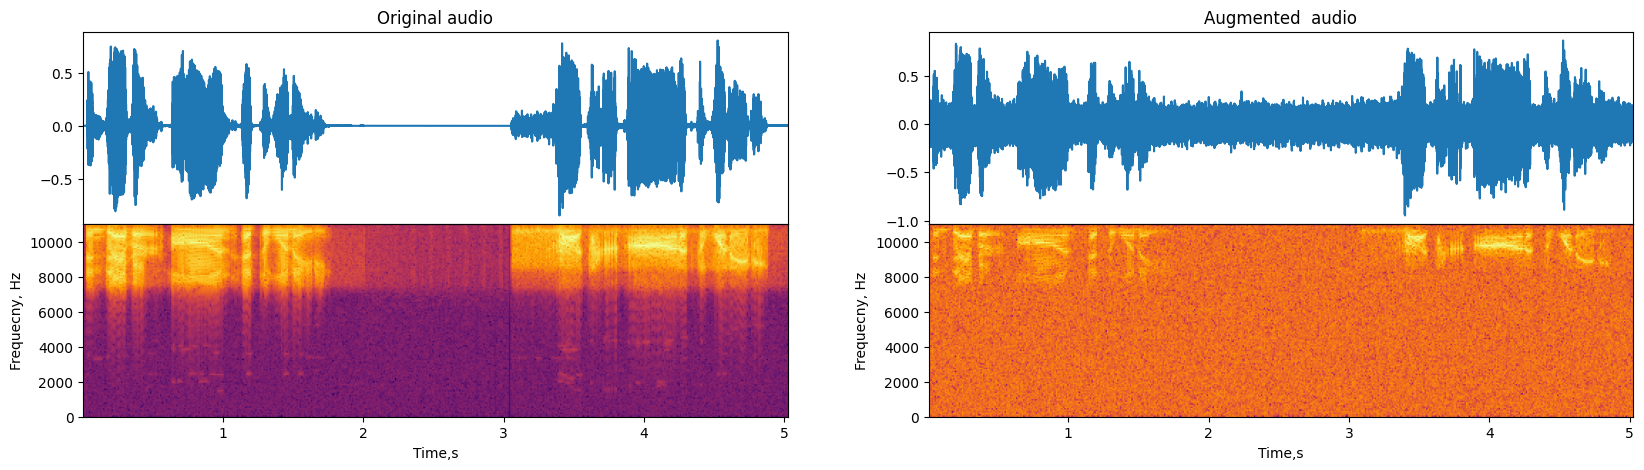

In [ ]:
import numpy as np
from scipy.signal import spectrogram
from matplotlib import pyplot as plt


def produce_plots(input_audio_arr, aug_audio, sr):
    f, t, Sxx_in = spectrogram(
        input_audio_arr, fs=sr
    )  # Compute spectrogram for the original signal (f - frequency, t - time)
    f, t, Sxx_aug = spectrogram(aug_audio, fs=sr)

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 5))

    ax[0, 0].plot(input_audio_arr)
    ax[0, 0].set_xlim(0, len(input_audio_arr))
    ax[0, 0].set_xticks([])
    ax[0, 0].set_title("Original audio")

    ax[0, 1].plot(aug_audio)
    ax[0, 1].set_xlim(0, len(input_audio_arr))
    ax[0, 1].set_xticks([])
    ax[0, 1].set_title("Augmented  audio")

    ax[1, 0].imshow(
        np.log(Sxx_in),
        extent=[t.min(), t.max(), f.min(), f.max()],
        aspect="auto",
        cmap="inferno",
    )
    ax[1, 0].set_ylabel("Frequecny, Hz")
    ax[1, 0].set_xlabel("Time,s")

    ax[1, 1].imshow(
        np.log(Sxx_aug, where=Sxx_aug > 0),
        extent=[t.min(), t.max(), f.min(), f.max()],
        aspect="auto",
        cmap="inferno",
    )
    ax[1, 1].set_ylabel("Frequecny, Hz")
    ax[1, 1].set_xlabel("Time,s")

    plt.subplots_adjust(hspace=0)
    plt.show()


produce_plots(data, augmented_data, sr)

#### Time Stretch

In [ ]:
from audiomentations import TimeStretch

augment = TimeStretch(min_rate=0.8, max_rate=1.5, p=1)
augmented_data = augment(data, sample_rate=sr)

display(Audio(augmented_data, rate=sr))

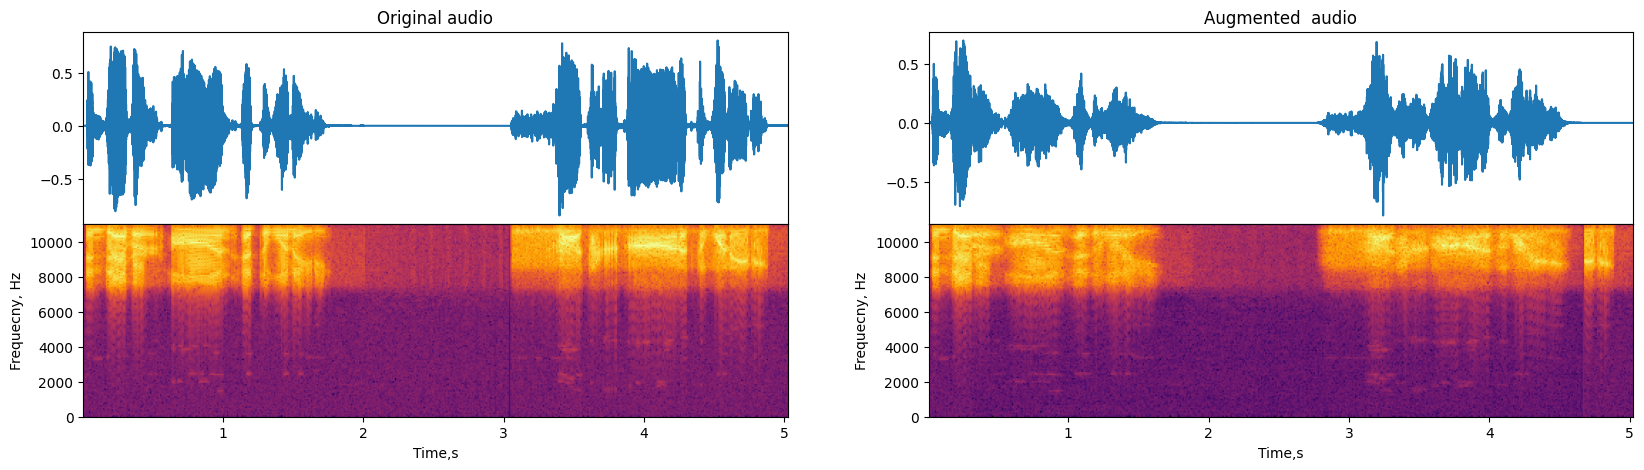

In [ ]:
produce_plots(data, augmented_data, sr)

#### Pitch Shift

Изменение тональности:

In [ ]:
from audiomentations import PitchShift

augment = PitchShift(min_semitones=1, max_semitones=12, p=1)
augmented_data = augment(data, sample_rate=sr)

display(Audio(augmented_data, rate=sr))

#### Совмещаем несколько аугментаций вместе

Как и в случае с картинками, мы можем совмещать несколько аугментаций вместе

In [ ]:
from audiomentations import Compose, AddGaussianNoise, Shift

augment = Compose(
    [
        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=1),
        TimeStretch(min_rate=0.8, max_rate=1.25, p=1),
        PitchShift(min_semitones=-4, max_semitones=4, p=1),
        # Shift(min_fraction=-0.5, max_fraction=0.5, p=1),
    ]
)

augmented_data = augment(data, sample_rate=sr)

display(Audio(augmented_data, rate=sr))

Посмотрим на то, что получилось:

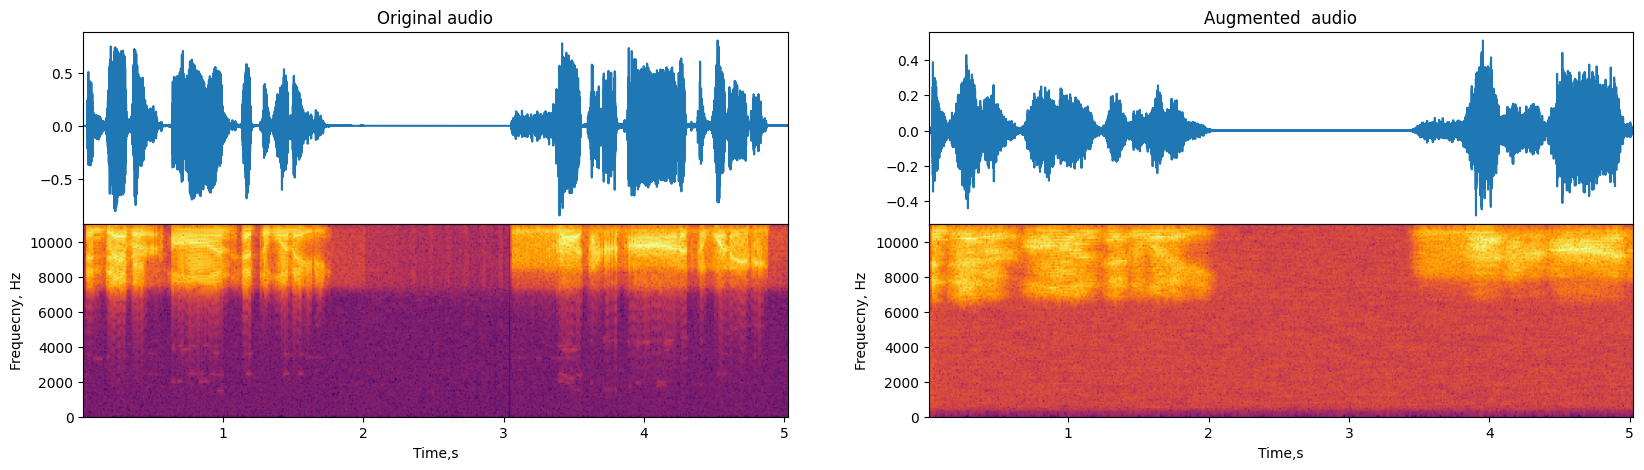

In [ ]:
produce_plots(data, augmented_data, sr)

Дополнительные библиотеки для аугментации звука (и волновых функций в целом):
- [[doc] 🛠️ torchaudio](https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html)
- [[git] 🐾 torch-audiomentations](https://github.com/asteroid-team/torch-audiomentations)
- [[git] 🐾 AugLy](https://github.com/facebookresearch/AugLy)

### Текст

Теперь рассмотрим несколько примеров аугментаций текста. С полным списком можно ознакомиться здесь: [nlpaug 🐾[git]](https://github.com/makcedward/nlpaug).

In [ ]:
!pip install -q nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 3.5 MB/s eta 0:00:00


In [ ]:
# Define input text
text = "Hello, future of AI for Science! How are you today?"
print(f"input text: {text}")

input text: Hello, future of AI for Science! How are you today?


#### Аугментация символов

Заменой на похоже выглядящие:

In [ ]:
import nlpaug.augmenter.char as nac

augment = nac.OcrAug()
augmented_text = augment.augment(text)

print(f"Original:\n{text}")
print(f"Augmented Texts:\n{augmented_text}")

Original:
Hello, future of AI for Science! How are you today?
Augmented Texts:
['Hello, future of AI for Science! H0w ake you tuday?']


С опечатками, которые учитывают расположение символов на клавиатуре:

In [ ]:
augment = nac.KeyboardAug()
augmented_text = augment.augment(text)

print(f"Original:\n{text}")
print(f"Augmented Texts:\n{augmented_text}")

Original:
Hello, future of AI for Science! How are you today?
Augmented Texts:
['HW<lo, fkgure of AI for SsieBcS! How are you HoSay?']


#### Аугментация слов

С орфографическими ошибками:

In [ ]:
import nlpaug.augmenter.word as naw

augment = naw.SpellingAug()
augmented_text = augment.augment(text, n=3)

print(f"Original:\n{text}")
print(f"Augmented Texts:\n{augmented_text}")

Original:
Hello, future of AI for Science! How are you today?
Augmented Texts:
['Hello, feature of AI forth Sience! How are you todoy?', "Hello, future jf AI form Science! How are your's todaday?", 'Hello, future for AI fur Science! Hoe are lou today?']


С использованием модели для предсказания новых слов в зависимости от контекста:

In [ ]:
!pip install -q transformers

In [ ]:
from IPython.display import clear_output


# model_type: word2vec, glove or fasttext
augment = naw.ContextualWordEmbsAug(model_path="bert-base-uncased", action="insert")
augmented_text = augment.augment(text)

clear_output()
print(f"Original:\n{text}")
print(f"Augmented Texts:\n{augmented_text}")

Original:
Hello, future of AI for Science! How are you today?
Augmented Texts:
['hello, future hosts of our ai programming for science! how are they you today?']


#### Аугментация предложений

Мы можем перевести текстовые данные на какой-либо язык, а затем перевести их обратно на язык оригинала. Это может помочь сгенерировать текстовые данные с разными словами, сохраняя при этом контекст текстовых данных.

In [ ]:
!pip -q install sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 5.9 MB/s eta 0:00:00


In [ ]:
back_translation_aug = naw.BackTranslationAug(
    from_model_name="facebook/wmt19-en-de", to_model_name="facebook/wmt19-de-en"
)
augmented_text = back_translation_aug.augment(text)

clear_output()
print(f"Original:\n{text}")
print(f"Augmented Texts:\n{augmented_text}")

Original:
Hello, future of AI for Science! How are you today?
Augmented Texts:
['Hello, the future of AI for science! How are you doing today?']


*Instance Crossover Augmentation* — составление новых объектов класса из отдельных предложений того же класса. Например, есть два объекта одного класса "положительный отзыв":
- <font color='red'>очень удобное приложение. Мне понравилось им пользоваться</font>
- <font color='green'>класс! Отличный интерфейс</font>

Тогда можно составить новый объект того же класса из их частей:
- <font color='red'>очень удобное приложение!</font> <font color='green'>Отличный интерфейс</font>

Важно: при любых аугментациях текста на уровне предложений есть шанс создать странные и нелогичные объекты, поэтому использовать их следует с особой осторожностью.

Дополнительные  библиотеки для аугментации текста:

- [[git] 🐾 TextAugment](https://github.com/dsfsi/textaugment)
- [[git] 🐾 AugLy](https://github.com/facebookresearch/AugLy)

[[blog] ✏️ Обзор методов аугментации текста с примерами](https://amitness.com/2020/05/data-augmentation-for-nlp/)

#NLP метрики

[[blog] ✏️ Цикл постов об NLP-метриках](https://habr.com/ru/articles/745642/)

Глобально метрики качества машинного перевода можно подразделить на **традиционные** и **нейросетевые**.

1. Традиционные метрики сравнительно просты в расчете и прозрачны, наиболее известные из них разработаны до бума нейросетей. Чаще всего такие метрики основаны на подсчете числа совпадений символов / слов / cловосочетаний – их называют «lexic overlap metrics».

2. Большинство метрик, предложенных после 2016 года – нейросетевые. Первым шагом в применении нейросетей в расчете метрик стало использование векторных представлений слов (embeddings).

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L09/nlp_metrics.png" width="1000">

Сегодня наиболее используемые – метрики, предложенные до 2010 года, причем в 99% это BLEU.

##Традиционные метрики

Наиболее известны и употребимы такие традиционные метрики как: BLEU, NIST, ROUGE, METEOR, TER, chrF, chrF++, RIBES.

**BLEU**

BLEU (BiLingual Evaluation Understudy) — метрика, разработанная в IBM (Papineni et al.) в 2001. Основана на подсчете слов (unigrams) и словосочетаний (n‑grams) из машинного перевода, также встречающихся в эталоне. Далее это число делится на общее число слов и словосочетаний в машинном переводе — получается precision. К итоговому precision применяется корректировка — штраф за краткость (brevity penalty), чтобы избежать слишком высоких оценок BLEU для кратких и неполных переводов.

In [ ]:
from torchtext.data.metrics import bleu_score
candidate_corpus = [['My', 'full', 'pytorch', 'test'], ['Another', 'Sentence']]
references_corpus = [[['My', 'full', 'pytorch', 'test'], ['Completely', 'Different']], [['No', 'Match']]]
print (bleu_score(candidate_corpus, references_corpus))

0.8408964276313782


**ROUGE**

ROUGE (Recall-Oriented Understudy for Gisting Evaluation) – серия метрик, предложенная Chin-Yew Lin в 2004 для оценки качества решения задачи суммаризации текста.

Как и BLEU, ROUGE основаны на подсчете совпадений слов и словосочетаний в машинном переводе и в эталоне. Но для ROUGE считается не только precision, но и recall, а также параметр F1. Это позволяет обойтись без штрафа за краткость.

Разные метрики серии ROUGE различаются количеством слов, для которых ищутся совпадения:



<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L09/rouge.png" width="500"> </center>

**METEOR**

METEOR (Metric for Evaluation of Translation with Explicit ORdering) – метрика качества машинного перевода, предложенная Banerjee and Lavie в 2005.

Оценка основана на подсчете совпадений отдельных слов (unigrams), c расчетом precision, recall, а также обобщающего показателя гармонического среднего (Fmean). В качестве совпадений учитываются не только точные соответствия слов (как в BLEU или ROUGE), но и наличие однокоренных слов или синонимов.

Итоговая метрика METEOR рассчитывается путем применения к Fmean штрафа за малую длину либо отсутствие совпадающих n-grams.

# Задача Sequence-to-Sequence

Попробуем решить задачу **sequence-to-sequence**: преобразование последовательности $X$ длины $N$ в последовательность $Y$ длины $T$. $T$ **может быть не равно** $N$.

Примеры **sequence-to-sequence** задач:
*   машинный перевод,
*   генерация ответа на вопрос,
*   генерация описания картинки или видео.

Для решения таких задач  можно использовать две **RNN**: **кодировщик** и **декодировщик**.
* Задача **кодировщика**: обобщить информацию о **входной последовательности** $X = (x_1,..., x_N)$, сформировав **вектор контекста** $C$ фиксированного размера.
* Задача **декодировщика**: используя информацию из $C$, сформировать **выходную последовательность** $Y = (y_1, ..., y_T)$.

В качестве вектора $C$ можно использовать последнее **скрытое состояние** кодировщика $h_N$.

Таким образом:

* **вход** — последовательность  $\large x_1, \dots, x_N$;
* **выход** — последовательность  $\large y_1, \dots, y_T$.

Кодировщик на основании входной последовательности предсказывает **нулевое скрытое состояние декодировщика и вектор контекста** $\large с$, который часто равен финальному скрытому состоянию кодировщика.

**Кодировщик:** $\large h_i = f_w(x_i, h_{i_1})$

**Декодировщик:** $\large s_t = g_u(y_{t-1}, s_{t-1}, c)$

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L09/out/seq_to_seq_with_rnn.png" width="800">

При этом возникает следующая **проблема:** мы пропускаем информацию из входной последовательности через бутылочное горлышко — вектор фиксированного размера $h_N$. Что будет, если размер последовательности 1000?

**Идея:** использовать новый вектор контекста на каждом шаге.

В данном подходе мы используем один **вектор контекста** фиксированной длины $c$, в который собираем информацию со всей **входной последовательности** $(x_1,...,x_N)$.

**Входная последовательность** может содержать как единицы, так и тысячи элементов. В задаче машинного перевода **входной последовательностью** может быть:
* короткая фраза,
* абзац “Войны и мира”.

Контекст важен. Для генерации глагола в правильной форме нужно понимать, к какому существительному он относится, а для качественного перевода конца абзаца необходимо понимать, о чем шла речь в его начале.

**Проблемы Sequence-to-Sequence**

При этом возникают проблемы:
- **Вектор контекста** $c$ фиксированной длины не может вместить любое количество информации, поэтому для длинных последовательностей качество будет ухудшаться.
- На каждой итерации декодировщика **скрытое состояние** $s_t$ должно сохранять информацию о том, какие элементы **выходной последовательности** уже были сгенерированы. Если $s_t$ не способно вместить эту информацию, модель может зациклиться или потерять часть **выходной последовательности**.

**Вектор контекста** $c$ и **скрытые состояния** декодировщика $s_t$ являются “бутылочными горлышками” модели.

## Реализация

[[doc] 🛠️ Официальный туториал от Pytorch](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

[[doc] 🛠️ Language translation with TorchText](
https://pytorch.org/tutorials/beginner/torchtext_translation.html)

### Загрузка и предобработка данных

In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(" "):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Все файлы представлены в формате Unicode, поэтому для упрощения мы преобразуем символы Unicode в ASCII, сделаем все строчными и уберём большую часть знаков препинания.

In [ ]:
import re
import unicodedata


def unicodeToAscii(s):
    return "".join(
        c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn"
    )


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

Делим файл на строки, а строки — на пары.

In [ ]:
# !wget -q https://raw.githubusercontent.com/L1aoXingyu/seq2seq-translation/master/data/eng-fra.txt
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/eng-fra.txt

In [ ]:
from io import open


def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = (
        open("%s-%s.txt" % (lang1, lang2), encoding="utf-8").read().strip().split("\n")
    )

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split("\t")] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Для скорости сократим датасет до предложений не длинее 10 слов и отфильтруем апострофы.

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ",
    "i m ",
    "he is",
    "he s ",
    "she is",
    "she s ",
    "you are",
    "you re ",
    "we are",
    "we re ",
    "they are",
    "they re ",
)


def filterPair(p):
    return (
        len(p[0].split(" ")) < MAX_LENGTH
        and len(p[1].split(" ")) < MAX_LENGTH
        and p[1].startswith(eng_prefixes)
    )


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
import random


def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData("eng", "fra", True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
['ce n est pas du tout un gentleman', 'he is not at all a gentleman']


In [ ]:
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Теперь в нашем распоряжении есть два словаря и набор пар строк.
Определим структуру модели.

### Кодировщик-декодировщик

In [ ]:
from torch import nn
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

Вместо one_hot-векторов, используются [эмбеддинги 🛠️[doc]](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html) размером 1×256 (hidden size)



In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(
            batch_size, 1, dtype=torch.long, device=device
        ).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.forward_step(
                decoder_input, decoder_hidden
            )
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)  # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(
                    -1
                ).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return (
            decoder_outputs,
            decoder_hidden,
            None,
        )  # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

### Обучение

На вход модели будем подавать индексы слов для первой части пары из одного словаря, а на выходе ожидать индексы для соответствующей пары из другого.

In [ ]:
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData("eng", "fra", True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, : len(inp_ids)] = inp_ids
        target_ids[idx, : len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(
        torch.LongTensor(input_ids).to(device), torch.LongTensor(target_ids).to(device)
    )

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(
        train_data, sampler=train_sampler, batch_size=batch_size
    )
    return input_lang, output_lang, train_dataloader

In [ ]:
def train_epoch(
    dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion
):
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (- %s)" % (asMinutes(s), asMinutes(rs))

In [ ]:
from torch import optim


def train(
    train_dataloader,
    encoder,
    decoder,
    n_epochs,
    learning_rate=0.001,
    print_every=100,
    plot_every=100,
):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(
            train_dataloader,
            encoder,
            decoder,
            encoder_optimizer,
            decoder_optimizer,
            criterion,
        )
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(
                "%s (%d %d%%) %.4f"
                % (
                    timeSince(start, epoch / n_epochs),
                    epoch,
                    epoch / n_epochs * 100,
                    print_loss_avg,
                )
            )

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
plt.switch_backend("agg")


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

In [ ]:
hidden_size = 256
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, n_epochs=80, print_every=5, plot_every=5)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991


KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
plt.switch_backend("agg")


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

In [ ]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, _ = decoder(
            encoder_outputs, encoder_hidden
        )
        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()
        decoded_words = []
        for idx in decoded_ids:
            for i in range(0, len(idx)):
                if idx[i].item() == EOS_token:
                    decoded_words.append("<EOS>")
                    break
            decoded_words.append(output_lang.index2word[idx[i].item()])
    return decoded_words

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print(">", pair[0])
        print("=", pair[1])
        output_words = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = " ".join(output_words)
        print("<", output_sentence)
        print("")

In [ ]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

<font size = 5> *Пример работы с применением RNN в работе выпускника курса* </font>

В работе **Поиск артефактов на изображениях обзора ZTF при помощи нейронных сетей** решалась проблема траты огромного количества времени на ручное изучение изображений с кандидатами на значимые астрономические события.

Загвоздка заключалась в том, что:

* после алгоритмической предобработки слишком много артефактов по типу пролетевшего над телескопом самолёта;

* каждый кандидат — серия кадров во времени, количество кадров на одно наблюдение различно.


<center><img src ="https://imageup.ru/img70/4648133/astro_encoder.png"></center>


<center><em>Source: <a href="https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fthumb.tildacdn.com%2Ftild3638-6534-4162-b637-383166656363%2F-%2Fresize%2F42x%2F-%2Fformat%2Fwebp%2Fpresentation.png">Примеры артефактов и архитектура кодировщика. Семенихин Т. А., et al</a></em></center>



<center><img src ="https://imageup.ru/img37/4648121/astro_rnn.png" width="800"></center>



<center><em>Source: <a href="https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fthumb.tildacdn.com%2Ftild3638-6534-4162-b637-383166656363%2F-%2Fresize%2F42x%2F-%2Fformat%2Fwebp%2Fpresentation.png">Семенихин Т. А., et al</a></em></center>

Подробнее:

[[video] 📺 Видеозапись выступления](https://youtu.be/g_WeSLmyVO8)

[[slides] 📊 Презентация](https://thumb.tildacdn.com/tild3638-6534-4162-b637-383166656363/-/resize/42x/-/format/webp/presentation.png)

[[git] 🐾 Код](https://github.com/EduNetArchive/Semenikhin_RB_ZTF)

<font size = 5> *Применение LSTM и WaveNet* </font>

В работе **Deep Learning based Pedestrian Inertial Navigation:
Methods, Dataset and On-Device Inference** решалась задача пешеходной навигации.

Существенным ограничением является малое количество данных, поэтому большие архитектуры не могут быть обучены.

<center><img src ="https://imageup.ru/img219/4648645/imu_task.png" width="400"></center>

<center><em>Source: <a href="https://arxiv.org/abs/2001.04061">IMU task</a></em></center>



<center><img src ="https://imageup.ru/img130/4648654/imu_wavenet.png" width="600"></center>

<center><em>Source: <a href="https://arxiv.org/abs/2001.04061">IMU task</a></em></center>

Суть подхода [WaveNet ✏️[blog]](https://habr.com/ru/companies/Voximplant/articles/309648/), который оказался крайне полезен, заключается в том, что слои слои нейросети имеют разные факторы дилатации и позволяют ее рецептивному полю расти экспоненциально с глубиной и покрывать тысячи временных отрезков.

<font size=6>Литература</font>

<font size=5>Особенности данных:</font>
* [[blog] ✏️ Анализ временных рядов, применение нейросетей (1 часть)](https://habr.com/ru/articles/693562/)
* [[blog] ✏️ Forecasting Time Series with Auto-Arima](https://www.alldatascience.com/time-series/forecasting-time-series-with-auto-arima/)

<font size=5>Рекуррентные нейронные сети:</font>
* [[article] 🎓 Session-based Recommendations with Recurrent Neural Networks](https://www.researchgate.net/publication/284579100_Session-based_Recommendations_with_Recurrent_Neural_Networks)
* [[blog] ✏️ How to Remove Non-Stationarity From Time Series](https://www.kaggle.com/code/bextuychiev/how-to-remove-non-stationarity-from-time-series)
* [[blog] ✏️ A Guide to Time Series Forecasting in Python](https://builtin.com/data-science/time-series-forecasting-python)
* [[blog] ✏️ How to Check if Time Series Data is Stationary with Python?](https://www.geeksforgeeks.org/how-to-check-if-time-series-data-is-stationary-with-python/)
* [[blog] ✏️ Complete Guide on Time Series Analysis in Python](https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python)
* [[doc] 🛠️ Data transformations and forecasting models: what to use and when](https://people.duke.edu/~rnau/whatuse.htm)
* [[colab] 🥨 Time Series Prediction with LSTM Using PyTorch](https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb#scrollTo=NabsV8O5BBd5)

<font size=5>LSTM:</font>
* [[article] 📚 Long Short-Term Memory (Hochreiter & Schmidhuber, 1997)](http://www.bioinf.jku.at/publications/older/2604.pdf)
* [[blog] ✏️ Feature Scaling Data with Scikit-Learn for Machine Learning in Python](https://stackabuse.com/feature-scaling-data-with-scikit-learn-for-machine-learning-in-python/)
* [[blog] ✏️ Hands-On Machine Learning with Scikit-Learn and TensorFlow, ч.4](https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/ch04.html)
* [[arxiv] 🎓 How to avoid machine learning pitfalls:
a guide for academic researchers (Lones, 2023)](https://arxiv.org/pdf/2108.02497.pdf)
* [[blog] ✏️ A Beginner’s Guide on Recurrent Neural Networks with PyTorch](https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/)

<font size=5>Пример посимвольной генерации текста:</font>
* [[git] 🐾 RNN-walkthrough](https://github.com/gabrielloye/RNN-walkthrough/blob/master/main.ipynb)
* [[blog] ✏️ The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)

<font size=5>Представление данных:</font>
* [[wiki] 📚 TF-IDF](https://ru.wikipedia.org/wiki/TF-IDF)
* [[doc] 🛠️ sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
* [[doc] 🛠️ Ещё несколько способов взвешивания и отбора признаков](https://scikit-learn.org/stable/modules/feature_selection.html)
* [[doc] 🛠️ TF-IDF Vectorizer scikit-learn](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting)
* [[colab] 🥨 Подробное руководство по использованию Word2Vec](https://colab.research.google.com/drive/1OJF0k-E60sp9Vyoj1yWuoedGTrwRiTyj?usp=sharing)
* [[doc] 🛠️ Туториал PyTorch по применению эмбедингов в NLP](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html)
* [[blog] ✏️ NLP Course for you](https://lena-voita.github.io/nlp_course.html)
* [[git] 🐾 Курс по NLP от ШАД](https://github.com/yandexdataschool/nlp_course)

<font size=5>Аугментация:</font>
* [[git] 🐾 audiomentations](https://github.com/iver56/audiomentations)
* [[doc] 🛠️ torchaudio](https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html)
* [[git] 🐾 torch-audiomentations](https://github.com/asteroid-team/torch-audiomentations)
* [[git] 🐾 AugLy](https://github.com/facebookresearch/AugLy)
* [[git] 🐾 nlpaug](https://github.com/makcedward/nlpaug)
* [[git] 🐾 TextAugment](https://github.com/dsfsi/textaugment)
* [[blog] ✏️ Обзор методов аугментации текста с примерами](https://amitness.com/2020/05/data-augmentation-for-nlp/)

<font size=5>NLP метрики:</font>
* [[blog] ✏️ Цикл постов об NLP-метриках](https://habr.com/ru/articles/745642/)